## 1. Libraries 📖

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import json 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn import metrics

import matplotlib.pyplot as plt

np.random.seed(1234)

## 2. Metrics 📏

In [2]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square, '\n')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

## 3. Load data 📊

In [3]:
df_train = pd.read_csv("../../data/train/protein/protein_klek_train.csv")
df_test = pd.read_csv("../../data/train/protein/protein_klek_test.csv")
df_valid = pd.read_csv("../../data/train/protein/protein_klek_valid.csv")

df_train_all = pd.concat([df_train, df_valid])

In [4]:
X_train_all = df_train_all.loc[:, df_train_all.columns != 'protein_plasma_binding']
y_train_all = df_train_all['protein_plasma_binding']

X_train = df_train.loc[:, df_train.columns != 'protein_plasma_binding']
y_train = df_train['protein_plasma_binding']

X_test = df_test.loc[:, df_test.columns != 'protein_plasma_binding']
y_test = df_test['protein_plasma_binding']

X_valid = df_valid.loc[:, df_valid.columns != 'protein_plasma_binding']
y_valid = df_valid['protein_plasma_binding']

In [5]:
with open('../../klek_idxs.txt', 'r') as f:
    idxs = json.load(f) 
X_train_all = X_train_all[idxs['protein']]
X_train = X_train[idxs['protein']]
X_test = X_test[idxs['protein']]
X_valid = X_valid[idxs['protein']]

In [6]:
X_train.shape

(1864, 639)

In [7]:
X_test.shape

(533, 639)

In [8]:
X_valid.shape

(266, 639)

# 4. Model ⚙️

![FCNN](images/fcnn.png)

In [9]:
class FCNN(nn.Module):
    def __init__(self):
        super(FCNN, self).__init__()
        self.linear1 = nn.Linear(639, 300)
        self.linear2 = nn.Linear(300, 500)
        self.linear3 = nn.Linear(500, 600)
        self.linear4 = nn.Linear(600, 400)
        self.linear5 = nn.Linear(400, 50)
        self.linear6 = nn.Linear(50, 1)
        self.dropout = torch.nn.Dropout(0.5)
        self.batch = torch.nn.BatchNorm1d(500)
        self.batch2 = torch.nn.BatchNorm1d(600)
        
    def forward(self, x):
        y_pred = F.relu(self.linear1(x))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch(self.linear2(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.batch2(self.linear3(y_pred)))
        y_pred = self.dropout(y_pred)
        y_pred = F.relu(self.linear4(y_pred))
        y_pred = F.relu(self.linear5(y_pred))
        y_pred = self.dropout(y_pred)
        y_pred = self.linear6(y_pred)
        return y_pred

## 4.1. Grid search 🔎

In [10]:
lrs = [0.001, 0.005, 0.01, 0.05]
batch_sizes = [32, 64, 128, 256]

In [11]:
best_value = 1000
best_params = {'lr': None, 'batch_size': None, 'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
train_losses_all = []
test_losses_all = []
train_accs_all = []
test_accs_all = []

for lr in lrs:
    for batch_size in batch_sizes:
        
        model = FCNN()
        model.cuda()
        
        train_dataset = TensorDataset(torch.FloatTensor(X_train.values), torch.FloatTensor(y_train.values.reshape(-1, 1)))
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

        valid_dataset = TensorDataset(torch.FloatTensor(X_valid.values), torch.FloatTensor(y_valid.values.reshape(-1, 1)))
        valid_loader = DataLoader(valid_dataset, batch_size=266, shuffle=False)

        epochs = 300
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr)

        train_losses = []
        test_losses = []
        train_accs = []
        test_accs = []
        
        print('Model: lr {}, batch_size {}'.format(lr, batch_size))

        for epoch in range(1, epochs + 1):

            print('################## EPOCH {} ##################'.format(epoch))

            model.train()
            train_correct = 0
            train_loss = 0


            for batch_idx, (data, target) in enumerate(train_loader):
                data, target = data.cuda(), target.cuda()
                optimizer.zero_grad()
                output = model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            train_loss /= len(train_loader)
            train_losses.append(train_loss)
            train_acc = train_correct/len(train_loader)
            train_accs.append(train_acc)
            print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))

            model.eval()

            test_loss = 0
            test_correct = 0

            with torch.no_grad():
                for data, target in valid_loader:
                    data, target = data.cuda(), target.cuda()
                    output = model(data)
                    test_loss += criterion(output, target).item()
                    test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())

            test_loss /= len(valid_loader)
            test_losses.append(test_loss)
            test_acc =test_correct/len(valid_loader)
            test_accs.append(test_acc)

            if test_loss<best_value:
                best_value = test_loss
                best_params['lr'] = lr
                best_params['batch_size'] = batch_size
                best_params['epoch'] = epoch
                best_params['train_loss'] = train_loss
                best_params['test_loss'] = test_loss
                best_params['train_acc'] = train_acc
                best_params['test_acc'] = test_acc 
            print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

        train_losses_all.append(train_losses)
        test_losses_all.append(test_losses)
        train_accs_all.append(train_accs)
        test_accs_all.append(test_accs)

print(best_params)

Model: lr 0.001, batch_size 32
################## EPOCH 1 ##################
Train Avg. loss: 2913.6290128029, Accuracy: -7.143024995955328
Test Avg. loss: 2199.77587890625, Accuracy: -2.6923657226482107
################## EPOCH 2 ##################
Train Avg. loss: 936.2890428446107, Accuracy: -1.8643860857526218
Test Avg. loss: 1371.9591064453125, Accuracy: -1.3028595725343566
################## EPOCH 3 ##################
Train Avg. loss: 891.0972817631091, Accuracy: -1.495298686236579
Test Avg. loss: 1184.1602783203125, Accuracy: -0.9876355493380853
################## EPOCH 4 ##################
Train Avg. loss: 793.8302234714314, Accuracy: -1.2427151988287086
Test Avg. loss: 1070.072998046875, Accuracy: -0.7961379993709148
################## EPOCH 5 ##################
Train Avg. loss: 801.0354138390493, Accuracy: -1.410614917636791
Test Avg. loss: 775.145263671875, Accuracy: -0.3010961406060464
################## EPOCH 6 ##################
Train Avg. loss: 778.8515350859044, Accurac

Train Avg. loss: 517.8204128459348, Accuracy: -0.7291916694817983
Test Avg. loss: 335.62652587890625, Accuracy: 0.4366444445531036
################## EPOCH 48 ##################
Train Avg. loss: 537.4075938079317, Accuracy: -0.7510236073038234
Test Avg. loss: 322.82708740234375, Accuracy: 0.4581286057229854
################## EPOCH 49 ##################
Train Avg. loss: 473.46863103317, Accuracy: -0.5205882055385823
Test Avg. loss: 350.5076904296875, Accuracy: 0.4116661685879306
################## EPOCH 50 ##################
Train Avg. loss: 510.643441410388, Accuracy: -0.6837934051518474
Test Avg. loss: 345.10980224609375, Accuracy: 0.4207266116734668
################## EPOCH 51 ##################
Train Avg. loss: 516.6288602150092, Accuracy: -0.5991664806023734
Test Avg. loss: 349.920654296875, Accuracy: 0.4126514535267072
################## EPOCH 52 ##################
Train Avg. loss: 488.4649373717227, Accuracy: -0.5932157027860836
Test Avg. loss: 336.86553955078125, Accuracy: 0.43

Train Avg. loss: 446.1866548182601, Accuracy: -0.4256551572672175
Test Avg. loss: 291.27459716796875, Accuracy: 0.51109000845781
################## EPOCH 95 ##################
Train Avg. loss: 428.69252660719013, Accuracy: -0.3765644350628359
Test Avg. loss: 289.8128967285156, Accuracy: 0.5135434769300993
################## EPOCH 96 ##################
Train Avg. loss: 439.07242959232656, Accuracy: -0.4611275052149365
Test Avg. loss: 283.4331359863281, Accuracy: 0.5242520799705002
################## EPOCH 97 ##################
Train Avg. loss: 451.9474595926576, Accuracy: -0.5187898485083855
Test Avg. loss: 283.3479919433594, Accuracy: 0.5243949660819812
################## EPOCH 98 ##################
Train Avg. loss: 427.33002562442067, Accuracy: -0.40738515257850105
Test Avg. loss: 274.9173583984375, Accuracy: 0.5385459169465605
################## EPOCH 99 ##################
Train Avg. loss: 421.9722807286149, Accuracy: -0.3592422786587633
Test Avg. loss: 281.19268798828125, Accuracy: 

Train Avg. loss: 392.97548455707096, Accuracy: -0.2958418937468132
Test Avg. loss: 232.01768493652344, Accuracy: 0.6105538810612794
################## EPOCH 141 ##################
Train Avg. loss: 400.43446841482387, Accuracy: -0.2796302449292406
Test Avg. loss: 248.96719360351562, Accuracy: 0.5821038267350339
################## EPOCH 142 ##################
Train Avg. loss: 423.0448127358647, Accuracy: -0.44330995248729366
Test Avg. loss: 243.4318389892578, Accuracy: 0.591395000750373
################## EPOCH 143 ##################
Train Avg. loss: 379.7841036521782, Accuracy: -0.29872757374903713
Test Avg. loss: 246.72398376464844, Accuracy: 0.5858690675218923
################## EPOCH 144 ##################
Train Avg. loss: 383.8398634053893, Accuracy: -0.32315079038744277
Test Avg. loss: 252.2435760498047, Accuracy: 0.5766043614502678
################## EPOCH 145 ##################
Train Avg. loss: 372.24279397220937, Accuracy: -0.1808806039156607
Test Avg. loss: 256.0870666503906, A

Train Avg. loss: 386.323117013705, Accuracy: -0.26404262602318734
Test Avg. loss: 253.28689575195312, Accuracy: 0.5748530743759033
################## EPOCH 187 ##################
Train Avg. loss: 372.2956540382515, Accuracy: -0.2159542900688261
Test Avg. loss: 270.8343505859375, Accuracy: 0.5453993394181456
################## EPOCH 188 ##################
Train Avg. loss: 371.34179015078786, Accuracy: -0.24344648703835356
Test Avg. loss: 269.5427551269531, Accuracy: 0.5475673400367367
################## EPOCH 189 ##################
Train Avg. loss: 380.93381745936506, Accuracy: -0.19102490280051834
Test Avg. loss: 246.0303497314453, Accuracy: 0.5870333506391456
################## EPOCH 190 ##################
Train Avg. loss: 386.0954145011255, Accuracy: -0.23420622492769924
Test Avg. loss: 299.6077575683594, Accuracy: 0.4971026301504622
################## EPOCH 191 ##################
Train Avg. loss: 369.2437426033667, Accuracy: -0.15998511442830982
Test Avg. loss: 310.60107421875, Accu

Train Avg. loss: 354.90256383863544, Accuracy: -0.17318449410628511
Test Avg. loss: 234.37063598632812, Accuracy: 0.6066044141435742
################## EPOCH 233 ##################
Train Avg. loss: 319.51431196827, Accuracy: 0.009083004356607116
Test Avg. loss: 264.0023498535156, Accuracy: 0.5568669518553002
################## EPOCH 234 ##################
Train Avg. loss: 349.8500707594015, Accuracy: -0.14423101547894826
Test Avg. loss: 242.6147003173828, Accuracy: 0.5927665527083825
################## EPOCH 235 ##################
Train Avg. loss: 348.79657810017216, Accuracy: -0.13262095065197996
Test Avg. loss: 254.35218811035156, Accuracy: 0.5730649971735207
################## EPOCH 236 ##################
Train Avg. loss: 338.30204876398636, Accuracy: -0.19300243999892372
Test Avg. loss: 256.88006591796875, Accuracy: 0.5688218922605953
################## EPOCH 237 ##################
Train Avg. loss: 358.35521788516286, Accuracy: -0.2218024954646449
Test Avg. loss: 252.05738830566406

Train Avg. loss: 341.42425588834084, Accuracy: -0.15249409207667347
Test Avg. loss: 259.2388610839844, Accuracy: 0.5648625645421697
################## EPOCH 279 ##################
Train Avg. loss: 312.61413276801676, Accuracy: -0.07727950057454887
Test Avg. loss: 257.0289001464844, Accuracy: 0.568572063382625
################## EPOCH 280 ##################
Train Avg. loss: 301.9786948511156, Accuracy: -0.011433233483658925
Test Avg. loss: 267.9872131347656, Accuracy: 0.5501783276408401
################## EPOCH 281 ##################
Train Avg. loss: 338.2438514838784, Accuracy: -0.15075324529033104
Test Avg. loss: 238.460205078125, Accuracy: 0.5997399535507604
################## EPOCH 282 ##################
Train Avg. loss: 311.5024129576602, Accuracy: -0.03417142733064909
Test Avg. loss: 246.0677947998047, Accuracy: 0.5869705300481607
################## EPOCH 283 ##################
Train Avg. loss: 314.64903259277344, Accuracy: -0.07985930056677305
Test Avg. loss: 245.05056762695312, 

Train Avg. loss: 612.8642283121745, Accuracy: -0.46805421626054333
Test Avg. loss: 475.7796630859375, Accuracy: 0.20139472598251273
################## EPOCH 26 ##################
Train Avg. loss: 604.4238174438476, Accuracy: -0.41487183054467214
Test Avg. loss: 603.809326171875, Accuracy: -0.013505584927034908
################## EPOCH 27 ##################
Train Avg. loss: 587.3827453613281, Accuracy: -0.41113355796991885
Test Avg. loss: 530.234619140625, Accuracy: 0.1099911336097289
################## EPOCH 28 ##################
Train Avg. loss: 576.9212788899739, Accuracy: -0.3289665686548692
Test Avg. loss: 451.0646667480469, Accuracy: 0.24287936469142313
################## EPOCH 29 ##################
Train Avg. loss: 611.0680938720703, Accuracy: -0.4380921588004789
Test Avg. loss: 383.43585205078125, Accuracy: 0.3563955883568497
################## EPOCH 30 ##################
Train Avg. loss: 565.1648310343425, Accuracy: -0.4080888516743929
Test Avg. loss: 459.59393310546875, Accura

Test Avg. loss: 362.7146911621094, Accuracy: 0.39117639392684755
################## EPOCH 73 ##################
Train Avg. loss: 510.2972106933594, Accuracy: -0.21240952883591607
Test Avg. loss: 397.8320617675781, Accuracy: 0.33223129187723677
################## EPOCH 74 ##################
Train Avg. loss: 498.1590138753255, Accuracy: -0.16175779073991509
Test Avg. loss: 340.3949890136719, Accuracy: 0.42864049111908586
################## EPOCH 75 ##################
Train Avg. loss: 489.47325439453124, Accuracy: -0.13697366934462984
Test Avg. loss: 393.8899841308594, Accuracy: 0.3388480948496746
################## EPOCH 76 ##################
Train Avg. loss: 494.67450459798175, Accuracy: -0.22901490765083657
Test Avg. loss: 351.9432067871094, Accuracy: 0.4092565889426848
################## EPOCH 77 ##################
Train Avg. loss: 515.307285563151, Accuracy: -0.2551511694810787
Test Avg. loss: 345.6605529785156, Accuracy: 0.4198021289531617
################## EPOCH 78 ###############

Train Avg. loss: 474.9440897623698, Accuracy: -0.1449702499026894
Test Avg. loss: 288.0155334472656, Accuracy: 0.5165604064599312
################## EPOCH 120 ##################
Train Avg. loss: 463.748573811849, Accuracy: -0.07973117352083207
Test Avg. loss: 295.6537170410156, Accuracy: 0.5037395808110244
################## EPOCH 121 ##################
Train Avg. loss: 463.7115743001302, Accuracy: -0.12065358499843007
Test Avg. loss: 282.9327697753906, Accuracy: 0.5250918810098302
################## EPOCH 122 ##################
Train Avg. loss: 456.80629374186196, Accuracy: -0.09298958337303985
Test Avg. loss: 345.395263671875, Accuracy: 0.42024740449254583
################## EPOCH 123 ##################
Train Avg. loss: 456.3144175211589, Accuracy: -0.10028893348772389
Test Avg. loss: 275.8256530761719, Accuracy: 0.5370213561633126
################## EPOCH 124 ##################
Train Avg. loss: 434.624550374349, Accuracy: -0.0585343787483544
Test Avg. loss: 347.0736083984375, Accura

Train Avg. loss: 417.2253916422526, Accuracy: 0.055987304444808005
Test Avg. loss: 368.8190612792969, Accuracy: 0.38093017135131757
################## EPOCH 167 ##################
Train Avg. loss: 423.17374114990236, Accuracy: 0.00036607645268632214
Test Avg. loss: 277.73944091796875, Accuracy: 0.5338090150085733
################## EPOCH 168 ##################
Train Avg. loss: 435.2130900065104, Accuracy: -0.022100646500250846
Test Avg. loss: 323.90155029296875, Accuracy: 0.45632504383162364
################## EPOCH 169 ##################
Train Avg. loss: 461.62395935058595, Accuracy: -0.10900953735843076
Test Avg. loss: 285.77825927734375, Accuracy: 0.5203157776387561
################## EPOCH 170 ##################
Train Avg. loss: 446.8107981363932, Accuracy: -0.03491272256913548
Test Avg. loss: 329.36419677734375, Accuracy: 0.4471558966643686
################## EPOCH 171 ##################
Train Avg. loss: 455.9906778971354, Accuracy: -0.07132275021564576
Test Avg. loss: 313.8124389

Train Avg. loss: 415.85980631510415, Accuracy: 0.030909604051004635
Test Avg. loss: 313.7818603515625, Accuracy: 0.4733111882536102
################## EPOCH 214 ##################
Train Avg. loss: 398.07929178873695, Accuracy: 0.04202170177009608
Test Avg. loss: 283.5028381347656, Accuracy: 0.5241350962959144
################## EPOCH 215 ##################
Train Avg. loss: 396.19227447509763, Accuracy: 0.05835584515434848
Test Avg. loss: 270.52520751953125, Accuracy: 0.5459182711432677
################## EPOCH 216 ##################
Train Avg. loss: 413.18725433349607, Accuracy: 0.0288557865472149
Test Avg. loss: 342.22216796875, Accuracy: 0.4255735552741865
################## EPOCH 217 ##################
Train Avg. loss: 422.2167394002279, Accuracy: -0.01711317696028701
Test Avg. loss: 274.24334716796875, Accuracy: 0.5396773255566027
################## EPOCH 218 ##################
Train Avg. loss: 425.0203135172526, Accuracy: -0.042058224451066106
Test Avg. loss: 273.5562744140625, Ac

Train Avg. loss: 386.2916249593099, Accuracy: 0.07041823563241266
Test Avg. loss: 271.78173828125, Accuracy: 0.5438091898280888
################## EPOCH 261 ##################
Train Avg. loss: 401.63438720703124, Accuracy: 0.05738785001917613
Test Avg. loss: 342.8521728515625, Accuracy: 0.424516048806471
################## EPOCH 262 ##################
Train Avg. loss: 411.72011108398436, Accuracy: 0.042788172788627586
Test Avg. loss: 283.2685546875, Accuracy: 0.5245282535326617
################## EPOCH 263 ##################
Train Avg. loss: 402.0944498697917, Accuracy: 0.054205885542506806
Test Avg. loss: 285.47369384765625, Accuracy: 0.5208269509140349
################## EPOCH 264 ##################
Train Avg. loss: 417.44236958821614, Accuracy: 0.00815578953020107
Test Avg. loss: 268.9713134765625, Accuracy: 0.5485265046692173
################## EPOCH 265 ##################
Train Avg. loss: 364.1697031656901, Accuracy: 0.09160689375352705
Test Avg. loss: 275.3031005859375, Accuracy:

Train Avg. loss: 816.5677164713542, Accuracy: -0.6745161341309847
Test Avg. loss: 1506.71240234375, Accuracy: -1.5290457210302373
################## EPOCH 8 ##################
Train Avg. loss: 786.3919189453125, Accuracy: -0.6326198354027919
Test Avg. loss: 1363.8116455078125, Accuracy: -1.289183732254782
################## EPOCH 9 ##################
Train Avg. loss: 729.8981038411458, Accuracy: -0.5045014380243664
Test Avg. loss: 1331.8089599609375, Accuracy: -1.2354671031737454
################## EPOCH 10 ##################
Train Avg. loss: 717.5960205078125, Accuracy: -0.48645134080938457
Test Avg. loss: 1128.2064208984375, Accuracy: -0.8937161907485458
################## EPOCH 11 ##################
Train Avg. loss: 691.8560994466146, Accuracy: -0.4434446913692786
Test Avg. loss: 1087.1951904296875, Accuracy: -0.8248777934236682
################## EPOCH 12 ##################
Train Avg. loss: 711.3268636067709, Accuracy: -0.48727837680516556
Test Avg. loss: 1239.2281494140625, Accura

Train Avg. loss: 523.6645263671875, Accuracy: -0.10939440692376076
Test Avg. loss: 385.45147705078125, Accuracy: 0.35301231646274356
################## EPOCH 54 ##################
Train Avg. loss: 528.7719991048177, Accuracy: -0.10036592080314599
Test Avg. loss: 461.2936096191406, Accuracy: 0.2257098163972775
################## EPOCH 55 ##################
Train Avg. loss: 534.308251953125, Accuracy: -0.11462385886219012
Test Avg. loss: 499.1339416503906, Accuracy: 0.16219414625141748
################## EPOCH 56 ##################
Train Avg. loss: 513.5525227864583, Accuracy: -0.07219672255775014
Test Avg. loss: 466.2948913574219, Accuracy: 0.2173151010317237
################## EPOCH 57 ##################
Train Avg. loss: 511.24013671875, Accuracy: -0.058937299944573564
Test Avg. loss: 422.6405029296875, Accuracy: 0.2905898068834858
################## EPOCH 58 ##################
Train Avg. loss: 528.9133239746094, Accuracy: -0.09704158641989367
Test Avg. loss: 382.9166259765625, Accurac

Train Avg. loss: 468.23700154622395, Accuracy: 0.04292687460511281
Test Avg. loss: 329.3111877441406, Accuracy: 0.4472448615802267
################## EPOCH 100 ##################
Train Avg. loss: 482.07476196289065, Accuracy: -0.017140565378860956
Test Avg. loss: 306.5633850097656, Accuracy: 0.48542750847292415
################## EPOCH 101 ##################
Train Avg. loss: 471.16651611328126, Accuracy: 0.02652067098147067
Test Avg. loss: 282.6742248535156, Accuracy: 0.5255258702536867
################## EPOCH 102 ##################
Train Avg. loss: 467.4912373860677, Accuracy: 0.027598381695770335
Test Avg. loss: 363.1372985839844, Accuracy: 0.3904671175710651
################## EPOCH 103 ##################
Train Avg. loss: 466.63499552408854, Accuracy: 0.017067002472064236
Test Avg. loss: 294.9027099609375, Accuracy: 0.5050001765782097
################## EPOCH 104 ##################
Train Avg. loss: 483.79796142578124, Accuracy: -0.017792312481549645
Test Avg. loss: 319.405853271484

Train Avg. loss: 443.20933837890624, Accuracy: 0.059098797560216146
Test Avg. loss: 285.92962646484375, Accuracy: 0.520061655563844
################## EPOCH 146 ##################
Train Avg. loss: 455.63075764973956, Accuracy: 0.04126022887607742
Test Avg. loss: 311.05230712890625, Accuracy: 0.47789276183050355
################## EPOCH 147 ##################
Train Avg. loss: 459.5822489420573, Accuracy: 0.04165778902535832
Test Avg. loss: 258.7182312011719, Accuracy: 0.565736473622386
################## EPOCH 148 ##################
Train Avg. loss: 449.9463785807292, Accuracy: 0.045519995919269036
Test Avg. loss: 300.95831298828125, Accuracy: 0.4948357779398299
################## EPOCH 149 ##################
Train Avg. loss: 425.52431437174477, Accuracy: 0.11423016058414506
Test Avg. loss: 284.1660461425781, Accuracy: 0.5230218956914916
################## EPOCH 150 ##################
Train Avg. loss: 482.24329833984376, Accuracy: -0.016192637173543148
Test Avg. loss: 270.5618591308594,

Train Avg. loss: 436.0404073079427, Accuracy: 0.09592149534358972
Test Avg. loss: 281.6906433105469, Accuracy: 0.5271768272958448
################## EPOCH 192 ##################
Train Avg. loss: 431.6938802083333, Accuracy: 0.09476559951635484
Test Avg. loss: 282.07452392578125, Accuracy: 0.5265325446964801
################## EPOCH 193 ##################
Train Avg. loss: 408.5031331380208, Accuracy: 0.1490219806152978
Test Avg. loss: 280.4058532714844, Accuracy: 0.5293334331446962
################## EPOCH 194 ##################
Train Avg. loss: 431.8715840657552, Accuracy: 0.09249711996907296
Test Avg. loss: 262.9353332519531, Accuracy: 0.558657986465086
################## EPOCH 195 ##################
Train Avg. loss: 424.8968505859375, Accuracy: 0.09485298944607165
Test Avg. loss: 261.3313293457031, Accuracy: 0.561350397692512
################## EPOCH 196 ##################
Train Avg. loss: 454.8528157552083, Accuracy: 0.042371894172907126
Test Avg. loss: 260.15948486328125, Accuracy:

Train Avg. loss: 428.6370402018229, Accuracy: 0.10301479966440512
Test Avg. loss: 245.71644592285156, Accuracy: 0.5875602302113712
################## EPOCH 239 ##################
Train Avg. loss: 427.74623616536456, Accuracy: 0.10867207200741932
Test Avg. loss: 249.5566864013672, Accuracy: 0.5811143263145324
################## EPOCH 240 ##################
Train Avg. loss: 420.3167338053385, Accuracy: 0.11831444993596717
Test Avg. loss: 259.9076843261719, Accuracy: 0.5637399601298358
################## EPOCH 241 ##################
Train Avg. loss: 410.64549153645834, Accuracy: 0.1303524960638278
Test Avg. loss: 330.5959167480469, Accuracy: 0.4450884255493639
################## EPOCH 242 ##################
Train Avg. loss: 442.84600219726565, Accuracy: 0.0768325883726927
Test Avg. loss: 289.3140563964844, Accuracy: 0.5143808119480178
################## EPOCH 243 ##################
Train Avg. loss: 408.84360758463544, Accuracy: 0.13436015013029992
Test Avg. loss: 311.75042724609375, Accur

Train Avg. loss: 406.5504170735677, Accuracy: 0.1453700401477741
Test Avg. loss: 269.94854736328125, Accuracy: 0.5468861911872269
################## EPOCH 286 ##################
Train Avg. loss: 389.2121561686198, Accuracy: 0.19190658090882895
Test Avg. loss: 264.697998046875, Accuracy: 0.5556993928910037
################## EPOCH 287 ##################
Train Avg. loss: 396.1588602701823, Accuracy: 0.16573127380380429
Test Avg. loss: 273.0796203613281, Accuracy: 0.5416306398015758
################## EPOCH 288 ##################
Train Avg. loss: 388.4626810709635, Accuracy: 0.18900820005571065
Test Avg. loss: 269.16607666015625, Accuracy: 0.5481996342616691
################## EPOCH 289 ##################
Train Avg. loss: 384.420458984375, Accuracy: 0.19136551481644465
Test Avg. loss: 265.04901123046875, Accuracy: 0.5551101624072445
################## EPOCH 290 ##################
Train Avg. loss: 427.7567565917969, Accuracy: 0.10670268774098203
Test Avg. loss: 255.5624237060547, Accuracy:

Train Avg. loss: 471.04922103881836, Accuracy: 0.03752559252939695
Test Avg. loss: 574.7050170898438, Accuracy: 0.03534666657822083
################## EPOCH 33 ##################
Train Avg. loss: 494.6092071533203, Accuracy: -0.007969055803609487
Test Avg. loss: 679.65380859375, Accuracy: -0.14081200472576838
################## EPOCH 34 ##################
Train Avg. loss: 488.8117485046387, Accuracy: -0.0003110117510638638
Test Avg. loss: 626.6076049804688, Accuracy: -0.05177285453859648
################## EPOCH 35 ##################
Train Avg. loss: 466.4096488952637, Accuracy: 0.05062743024020337
Test Avg. loss: 711.753173828125, Accuracy: -0.19469139100350752
################## EPOCH 36 ##################
Train Avg. loss: 483.9607810974121, Accuracy: 0.004245898367898765
Test Avg. loss: 523.7526245117188, Accuracy: 0.12087127890579252
################## EPOCH 37 ##################
Train Avg. loss: 468.3774108886719, Accuracy: 0.05205154814825999
Test Avg. loss: 663.1460571289062, Ac

Train Avg. loss: 435.77685546875, Accuracy: 0.10876391754054722
Test Avg. loss: 478.122314453125, Accuracy: 0.19746260562162798
################## EPOCH 81 ##################
Train Avg. loss: 405.5188522338867, Accuracy: 0.1775369222854481
Test Avg. loss: 369.8665466308594, Accuracy: 0.3791719529232255
################## EPOCH 82 ##################
Train Avg. loss: 420.99559783935547, Accuracy: 0.14248672884735383
Test Avg. loss: 467.5187683105469, Accuracy: 0.21526078644877966
################## EPOCH 83 ##################
Train Avg. loss: 402.0981559753418, Accuracy: 0.17834505065648593
Test Avg. loss: 374.16253662109375, Accuracy: 0.37196100685719635
################## EPOCH 84 ##################
Train Avg. loss: 400.4597358703613, Accuracy: 0.1819560653571355
Test Avg. loss: 411.26654052734375, Accuracy: 0.309681227577696
################## EPOCH 85 ##################
Train Avg. loss: 404.18932342529297, Accuracy: 0.17949720383603507
Test Avg. loss: 381.4904479980469, Accuracy: 0.3

Train Avg. loss: 379.2976608276367, Accuracy: 0.219111852494839
Test Avg. loss: 391.4410400390625, Accuracy: 0.342958744521897
################## EPOCH 128 ##################
Train Avg. loss: 400.5539207458496, Accuracy: 0.18575422829150273
Test Avg. loss: 317.21356201171875, Accuracy: 0.4675509615789676
################## EPOCH 129 ##################
Train Avg. loss: 395.3091049194336, Accuracy: 0.19172491290299287
Test Avg. loss: 274.8309020996094, Accuracy: 0.5386911093391884
################## EPOCH 130 ##################
Train Avg. loss: 387.5322074890137, Accuracy: 0.20808547088148543
Test Avg. loss: 352.83111572265625, Accuracy: 0.4077661749869702
################## EPOCH 131 ##################
Train Avg. loss: 400.45898818969727, Accuracy: 0.1784643537586669
Test Avg. loss: 384.6926574707031, Accuracy: 0.3542860106067023
################## EPOCH 132 ##################
Train Avg. loss: 406.98927307128906, Accuracy: 0.16636122604435816
Test Avg. loss: 333.2701110839844, Accuracy:

Train Avg. loss: 393.5234260559082, Accuracy: 0.19459472554949114
Test Avg. loss: 312.3205871582031, Accuracy: 0.4757639159519915
################## EPOCH 174 ##################
Train Avg. loss: 396.24289321899414, Accuracy: 0.1897453974676005
Test Avg. loss: 309.1575927734375, Accuracy: 0.4810730884164155
################## EPOCH 175 ##################
Train Avg. loss: 372.4969596862793, Accuracy: 0.23795042724570736
Test Avg. loss: 340.2996826171875, Accuracy: 0.4288005131409873
################## EPOCH 176 ##################
Train Avg. loss: 368.4482536315918, Accuracy: 0.24454722536231543
Test Avg. loss: 294.74676513671875, Accuracy: 0.5052619205625779
################## EPOCH 177 ##################
Train Avg. loss: 370.6650505065918, Accuracy: 0.23827289573493216
Test Avg. loss: 277.46807861328125, Accuracy: 0.5342645148614302
################## EPOCH 178 ##################
Train Avg. loss: 374.56348037719727, Accuracy: 0.23994564223808557
Test Avg. loss: 262.9462890625, Accuracy:

Test Avg. loss: 283.6646728515625, Accuracy: 0.5238633998106694
################## EPOCH 222 ##################
Train Avg. loss: 370.21057510375977, Accuracy: 0.24263152432588592
Test Avg. loss: 249.31954956054688, Accuracy: 0.5815123980170236
################## EPOCH 223 ##################
Train Avg. loss: 342.0249500274658, Accuracy: 0.3000224080384711
Test Avg. loss: 258.0410461425781, Accuracy: 0.5668731792532771
################## EPOCH 224 ##################
Train Avg. loss: 380.8674964904785, Accuracy: 0.22163382814162225
Test Avg. loss: 329.9258728027344, Accuracy: 0.4462131174153928
################## EPOCH 225 ##################
Train Avg. loss: 384.8000183105469, Accuracy: 0.21013926482035095
Test Avg. loss: 263.64898681640625, Accuracy: 0.557460184591261
################## EPOCH 226 ##################
Train Avg. loss: 357.5337944030762, Accuracy: 0.26968754874042133
Test Avg. loss: 327.745361328125, Accuracy: 0.4498731883050441
################## EPOCH 227 #################

Train Avg. loss: 352.065185546875, Accuracy: 0.2747829184403589
Test Avg. loss: 260.23980712890625, Accuracy: 0.5631825003446196
################## EPOCH 270 ##################
Train Avg. loss: 339.9324264526367, Accuracy: 0.31128652274818114
Test Avg. loss: 263.2778015136719, Accuracy: 0.5580831634023157
################## EPOCH 271 ##################
Train Avg. loss: 363.46104431152344, Accuracy: 0.25958841044509584
Test Avg. loss: 270.7912902832031, Accuracy: 0.5454716315456472
################## EPOCH 272 ##################
Train Avg. loss: 379.91727447509766, Accuracy: 0.2232159478777625
Test Avg. loss: 288.8123779296875, Accuracy: 0.5152228974360157
################## EPOCH 273 ##################
Train Avg. loss: 331.75592041015625, Accuracy: 0.3266301436567778
Test Avg. loss: 287.34259033203125, Accuracy: 0.517689939541357
################## EPOCH 274 ##################
Train Avg. loss: 358.95956802368164, Accuracy: 0.26591474035155727
Test Avg. loss: 315.2425231933594, Accuracy

Train Avg. loss: 641.0508252160024, Accuracy: -1.1669143770562307
Test Avg. loss: 450.0735168457031, Accuracy: 0.24454297127531965
################## EPOCH 16 ##################
Train Avg. loss: 664.3714553057138, Accuracy: -1.2298919972375877
Test Avg. loss: 396.0968322753906, Accuracy: 0.33514387387130995
################## EPOCH 17 ##################
Train Avg. loss: 639.6918810828257, Accuracy: -1.065346827222189
Test Avg. loss: 379.7870788574219, Accuracy: 0.3625201238039504
################## EPOCH 18 ##################
Train Avg. loss: 650.262760485633, Accuracy: -1.0250584764951494
Test Avg. loss: 378.60052490234375, Accuracy: 0.36451178541949125
################## EPOCH 19 ##################
Train Avg. loss: 632.0333272643009, Accuracy: -1.0973197140307742
Test Avg. loss: 385.3427429199219, Accuracy: 0.35319488155455026
################## EPOCH 20 ##################
Train Avg. loss: 643.0409959696107, Accuracy: -1.1378099971787536
Test Avg. loss: 340.5355529785156, Accuracy: 0

Train Avg. loss: 449.3796521202993, Accuracy: -0.567904673800217
Test Avg. loss: 236.24964904785156, Accuracy: 0.603450414966136
################## EPOCH 63 ##################
Train Avg. loss: 400.3621611514334, Accuracy: -0.33115794042312285
Test Avg. loss: 279.7293395996094, Accuracy: 0.5304689533383662
################## EPOCH 64 ##################
Train Avg. loss: 444.69205979169425, Accuracy: -0.44432883095459724
Test Avg. loss: 239.67958068847656, Accuracy: 0.5976932559028054
################## EPOCH 65 ##################
Train Avg. loss: 435.02403078240866, Accuracy: -0.3911097943440085
Test Avg. loss: 264.1990051269531, Accuracy: 0.556536871292769
################## EPOCH 66 ##################
Train Avg. loss: 432.26373653088586, Accuracy: -0.4326476750390998
Test Avg. loss: 248.56497192382812, Accuracy: 0.5827789245405784
################## EPOCH 67 ##################
Train Avg. loss: 419.3990372479972, Accuracy: -0.38506328423246633
Test Avg. loss: 245.19935607910156, Accurac

Train Avg. loss: 357.3994319075245, Accuracy: -0.10541282141258038
Test Avg. loss: 275.7657470703125, Accuracy: 0.5371218908982616
################## EPOCH 109 ##################
Train Avg. loss: 365.4934309619968, Accuracy: -0.19241929903993468
Test Avg. loss: 233.29403686523438, Accuracy: 0.6084114994892624
################## EPOCH 110 ##################
Train Avg. loss: 331.362024856826, Accuracy: -0.0667188664796354
Test Avg. loss: 240.23452758789062, Accuracy: 0.596761740867717
################## EPOCH 111 ##################
Train Avg. loss: 339.0299858481197, Accuracy: -0.05102503789314782
Test Avg. loss: 236.95216369628906, Accuracy: 0.6022712639948005
################## EPOCH 112 ##################
Train Avg. loss: 344.79493299581236, Accuracy: -0.11052596272226334
Test Avg. loss: 235.2252197265625, Accuracy: 0.6051699458446747
################## EPOCH 113 ##################
Train Avg. loss: 338.7357821706998, Accuracy: -0.06417591520728666
Test Avg. loss: 233.03038024902344, A

Train Avg. loss: 288.6316324007713, Accuracy: 0.05999908068938006
Test Avg. loss: 264.4698181152344, Accuracy: 0.5560823533365178
################## EPOCH 155 ##################
Train Avg. loss: 300.0042802196438, Accuracy: 0.09797462836024597
Test Avg. loss: 261.11541748046875, Accuracy: 0.5617127736965262
################## EPOCH 156 ##################
Train Avg. loss: 302.98431525796144, Accuracy: 0.12301386515980518
Test Avg. loss: 272.2247619628906, Accuracy: 0.543065576783452
################## EPOCH 157 ##################
Train Avg. loss: 284.8363727634236, Accuracy: 0.11730169874637894
Test Avg. loss: 261.8182678222656, Accuracy: 0.5605329954890392
################## EPOCH 158 ##################
Train Avg. loss: 272.0466618942002, Accuracy: 0.21258169761125484
Test Avg. loss: 258.85394287109375, Accuracy: 0.5655087096110136
################## EPOCH 159 ##################
Train Avg. loss: 282.1703514487056, Accuracy: 0.10330269654260076
Test Avg. loss: 260.1949462890625, Accurac

Train Avg. loss: 251.63764009637347, Accuracy: 0.2637983811883278
Test Avg. loss: 273.1243591308594, Accuracy: 0.5415555467823137
################## EPOCH 201 ##################
Train Avg. loss: 247.14991501630362, Accuracy: 0.2727947702021389
Test Avg. loss: 282.7938232421875, Accuracy: 0.5253251062104496
################## EPOCH 202 ##################
Train Avg. loss: 248.3339775214761, Accuracy: 0.1973842853549928
Test Avg. loss: 287.6175842285156, Accuracy: 0.5172284121912036
################## EPOCH 203 ##################
Train Avg. loss: 235.12052839893406, Accuracy: 0.2295025819902725
Test Avg. loss: 303.5921630859375, Accuracy: 0.49041474948308417
################## EPOCH 204 ##################
Train Avg. loss: 240.18377194162142, Accuracy: 0.2688794282877647
Test Avg. loss: 287.2664489746094, Accuracy: 0.517817750220987
################## EPOCH 205 ##################
Train Avg. loss: 231.97810131008342, Accuracy: 0.2862241401934186
Test Avg. loss: 275.7666931152344, Accuracy: 

Train Avg. loss: 196.79267805713718, Accuracy: 0.36888174912111593
Test Avg. loss: 274.7538757324219, Accuracy: 0.5388203478647962
################## EPOCH 248 ##################
Train Avg. loss: 196.01569844908633, Accuracy: 0.38246747024306704
Test Avg. loss: 274.8142395019531, Accuracy: 0.5387190442854057
################## EPOCH 249 ##################
Train Avg. loss: 209.13563175524695, Accuracy: 0.33022669623147594
Test Avg. loss: 296.1089782714844, Accuracy: 0.5029754403383383
################## EPOCH 250 ##################
Train Avg. loss: 208.40610749842756, Accuracy: 0.38126464887753364
Test Avg. loss: 298.1734313964844, Accuracy: 0.49951014650054404
################## EPOCH 251 ##################
Train Avg. loss: 206.4214635299424, Accuracy: 0.355041124252722
Test Avg. loss: 282.1714172363281, Accuracy: 0.5263698841141888
################## EPOCH 252 ##################
Train Avg. loss: 199.8808772200245, Accuracy: 0.4102074186387667
Test Avg. loss: 291.2729187011719, Accurac

Train Avg. loss: 182.25394892288466, Accuracy: 0.44459150066960523
Test Avg. loss: 275.1193542480469, Accuracy: 0.5382068967461793
################## EPOCH 295 ##################
Train Avg. loss: 178.34843729310117, Accuracy: 0.47343311901103374
Test Avg. loss: 277.7864074707031, Accuracy: 0.5337302028846926
################## EPOCH 296 ##################
Train Avg. loss: 183.58143745034428, Accuracy: 0.4862976317982743
Test Avg. loss: 275.6600341796875, Accuracy: 0.5372993512653808
################## EPOCH 297 ##################
Train Avg. loss: 188.58607314804854, Accuracy: 0.48924393773799774
Test Avg. loss: 267.30975341796875, Accuracy: 0.5513154937916244
################## EPOCH 298 ##################
Train Avg. loss: 182.66093962071307, Accuracy: 0.4621361991746623
Test Avg. loss: 271.9154357910156, Accuracy: 0.5435847336189807
################## EPOCH 299 ##################
Train Avg. loss: 175.30817381002134, Accuracy: 0.4955946982090677
Test Avg. loss: 262.7369689941406, Accur

Train Avg. loss: 470.84784037272135, Accuracy: -0.1731327348834661
Test Avg. loss: 284.0291748046875, Accuracy: 0.5232516332917782
################## EPOCH 41 ##################
Train Avg. loss: 489.91771240234374, Accuracy: -0.1429434624319682
Test Avg. loss: 303.00421142578125, Accuracy: 0.49140165713607986
################## EPOCH 42 ##################
Train Avg. loss: 489.5277384440104, Accuracy: -0.14328672462922135
Test Avg. loss: 294.8491516113281, Accuracy: 0.5050900200729667
################## EPOCH 43 ##################
Train Avg. loss: 493.0065165201823, Accuracy: -0.18837824133703646
Test Avg. loss: 317.5315246582031, Accuracy: 0.4670172458708258
################## EPOCH 44 ##################
Train Avg. loss: 456.2528015136719, Accuracy: -0.11057871206445608
Test Avg. loss: 330.1470031738281, Accuracy: 0.44584195785758496
################## EPOCH 45 ##################
Train Avg. loss: 444.94986928304036, Accuracy: -0.12029328568291815
Test Avg. loss: 359.2746276855469, Accu

Train Avg. loss: 373.14490509033203, Accuracy: 0.09541246057367496
Test Avg. loss: 241.90615844726562, Accuracy: 0.5939558914691856
################## EPOCH 88 ##################
Train Avg. loss: 391.1553278605143, Accuracy: 0.05304364623235839
Test Avg. loss: 258.7127685546875, Accuracy: 0.565745686082636
################## EPOCH 89 ##################
Train Avg. loss: 372.0413564046224, Accuracy: 0.10128214165840885
Test Avg. loss: 267.3262023925781, Accuracy: 0.5512879231919157
################## EPOCH 90 ##################
Train Avg. loss: 415.09289601643883, Accuracy: 0.021905395992291073
Test Avg. loss: 275.8226623535156, Accuracy: 0.5370264185896769
################## EPOCH 91 ##################
Train Avg. loss: 388.9167780558268, Accuracy: 0.08425139016931919
Test Avg. loss: 245.9105682373047, Accuracy: 0.5872344245863427
################## EPOCH 92 ##################
Train Avg. loss: 359.9527974446615, Accuracy: 0.09594772151595657
Test Avg. loss: 322.8445739746094, Accuracy: 0

Train Avg. loss: 331.42101135253904, Accuracy: 0.22437875838735846
Test Avg. loss: 241.77658081054688, Accuracy: 0.5941733858424456
################## EPOCH 135 ##################
Train Avg. loss: 336.61103871663414, Accuracy: 0.20369087942812672
Test Avg. loss: 238.7602081298828, Accuracy: 0.5992364030885409
################## EPOCH 136 ##################
Train Avg. loss: 332.5066162109375, Accuracy: 0.1988752045708235
Test Avg. loss: 243.95921325683594, Accuracy: 0.590509798845468
################## EPOCH 137 ##################
Train Avg. loss: 343.1877899169922, Accuracy: 0.14537878821213168
Test Avg. loss: 251.2616424560547, Accuracy: 0.5782525788596782
################## EPOCH 138 ##################
Train Avg. loss: 333.5756856282552, Accuracy: 0.20507572180880082
Test Avg. loss: 249.7427215576172, Accuracy: 0.5808020766045069
################## EPOCH 139 ##################
Train Avg. loss: 346.49383239746095, Accuracy: 0.16497860059957448
Test Avg. loss: 264.1929016113281, Accura

Test Avg. loss: 231.4201202392578, Accuracy: 0.6115569247679065
################## EPOCH 181 ##################
Train Avg. loss: 295.11925608317057, Accuracy: 0.3104929362383819
Test Avg. loss: 247.42088317871094, Accuracy: 0.5846993267760543
################## EPOCH 182 ##################
Train Avg. loss: 304.7458129882813, Accuracy: 0.26794308038363873
Test Avg. loss: 255.1168975830078, Accuracy: 0.5717813973196002
################## EPOCH 183 ##################
Train Avg. loss: 300.46773020426434, Accuracy: 0.2691587803357064
Test Avg. loss: 260.1199645996094, Accuracy: 0.5633836607989723
################## EPOCH 184 ##################
Train Avg. loss: 302.2739730834961, Accuracy: 0.2716833798346677
Test Avg. loss: 258.1878662109375, Accuracy: 0.5666267334541967
################## EPOCH 185 ##################
Train Avg. loss: 283.2324910481771, Accuracy: 0.31684315553278375
Test Avg. loss: 230.0673828125, Accuracy: 0.6138275232345043
################## EPOCH 186 ##################
T

Train Avg. loss: 266.4169138590495, Accuracy: 0.36773972964652657
Test Avg. loss: 259.9736328125, Accuracy: 0.5636292767389486
################## EPOCH 228 ##################
Train Avg. loss: 243.11655095418294, Accuracy: 0.40935231516621
Test Avg. loss: 208.05995178222656, Accuracy: 0.6507673789443841
################## EPOCH 229 ##################
Train Avg. loss: 259.8107223510742, Accuracy: 0.400710945619608
Test Avg. loss: 227.98178100585938, Accuracy: 0.6173282152187096
################## EPOCH 230 ##################
Train Avg. loss: 275.97822799682615, Accuracy: 0.3467545564680567
Test Avg. loss: 237.09678649902344, Accuracy: 0.6020284841386426
################## EPOCH 231 ##################
Train Avg. loss: 255.68170827229818, Accuracy: 0.4070785078434332
Test Avg. loss: 234.8253173828125, Accuracy: 0.6058412055031364
################## EPOCH 232 ##################
Train Avg. loss: 269.6291269938151, Accuracy: 0.3659069428871575
Test Avg. loss: 231.9381561279297, Accuracy: 0.61

Test Avg. loss: 227.25181579589844, Accuracy: 0.6185534931496294
################## EPOCH 274 ##################
Train Avg. loss: 218.10929056803386, Accuracy: 0.4668748985680829
Test Avg. loss: 246.79251098632812, Accuracy: 0.5857540483966766
################## EPOCH 275 ##################
Train Avg. loss: 223.8992141723633, Accuracy: 0.4687145140199906
Test Avg. loss: 258.9523010253906, Accuracy: 0.5653436400293541
################## EPOCH 276 ##################
Train Avg. loss: 237.246479288737, Accuracy: 0.4450944966416684
Test Avg. loss: 258.31927490234375, Accuracy: 0.5664062072053979
################## EPOCH 277 ##################
Train Avg. loss: 233.7475809733073, Accuracy: 0.4507164020074631
Test Avg. loss: 260.289306640625, Accuracy: 0.5630994257787663
################## EPOCH 278 ##################
Train Avg. loss: 231.13372853597005, Accuracy: 0.4472720947918487
Test Avg. loss: 244.01112365722656, Accuracy: 0.590422656672298
################## EPOCH 279 ##################


Train Avg. loss: 511.42173461914064, Accuracy: -0.06904875304022422
Test Avg. loss: 416.75042724609375, Accuracy: 0.30047644828949693
################## EPOCH 21 ##################
Train Avg. loss: 516.0973368326823, Accuracy: -0.08379333559139616
Test Avg. loss: 343.7757873535156, Accuracy: 0.4229657375379555
################## EPOCH 22 ##################
Train Avg. loss: 520.5181986490885, Accuracy: -0.09537615998632336
Test Avg. loss: 422.0698547363281, Accuracy: 0.2915477128191777
################## EPOCH 23 ##################
Train Avg. loss: 492.26861368815105, Accuracy: -0.049439271732637936
Test Avg. loss: 383.694091796875, Accuracy: 0.35596214703348195
################## EPOCH 24 ##################
Train Avg. loss: 505.83777872721356, Accuracy: -0.046071750743430825
Test Avg. loss: 343.5397033691406, Accuracy: 0.4233620123588443
################## EPOCH 25 ##################
Train Avg. loss: 511.5925577799479, Accuracy: -0.06934402578557833
Test Avg. loss: 420.2998352050781, A

Train Avg. loss: 443.72357381184895, Accuracy: 0.07183135913770645
Test Avg. loss: 330.2545166015625, Accuracy: 0.44566148346837886
################## EPOCH 67 ##################
Train Avg. loss: 419.062538655599, Accuracy: 0.1244531117842024
Test Avg. loss: 311.7808837890625, Accuracy: 0.47666982490043397
################## EPOCH 68 ##################
Train Avg. loss: 436.5172973632813, Accuracy: 0.07622842324088842
Test Avg. loss: 309.77264404296875, Accuracy: 0.48004069256921156
################## EPOCH 69 ##################
Train Avg. loss: 411.8464762369792, Accuracy: 0.1441563793709479
Test Avg. loss: 282.1387634277344, Accuracy: 0.526424669872321
################## EPOCH 70 ##################
Train Avg. loss: 397.91314493815105, Accuracy: 0.1674470689736102
Test Avg. loss: 329.958740234375, Accuracy: 0.4461579314450028
################## EPOCH 71 ##################
Train Avg. loss: 396.13243204752604, Accuracy: 0.1672182826515312
Test Avg. loss: 276.5633239746094, Accuracy: 0.53

Train Avg. loss: 368.06773681640624, Accuracy: 0.2323189377492665
Test Avg. loss: 274.8328552246094, Accuracy: 0.5386877923088454
################## EPOCH 115 ##################
Train Avg. loss: 366.5022237141927, Accuracy: 0.23404531782974936
Test Avg. loss: 259.4102478027344, Accuracy: 0.5645749296340045
################## EPOCH 116 ##################
Train Avg. loss: 380.2341003417969, Accuracy: 0.20791732237047716
Test Avg. loss: 281.0140380859375, Accuracy: 0.5283125453141988
################## EPOCH 117 ##################
Train Avg. loss: 369.2726298014323, Accuracy: 0.23407072087338457
Test Avg. loss: 246.05247497558594, Accuracy: 0.5869962008436842
################## EPOCH 118 ##################
Train Avg. loss: 360.0301025390625, Accuracy: 0.24172022892790418
Test Avg. loss: 275.8336486816406, Accuracy: 0.5370079208102033
################## EPOCH 119 ##################
Train Avg. loss: 398.1765075683594, Accuracy: 0.17165935465032015
Test Avg. loss: 261.1850891113281, Accuracy

Train Avg. loss: 349.65601501464846, Accuracy: 0.25562805856231713
Test Avg. loss: 324.0950927734375, Accuracy: 0.45600022451525035
################## EPOCH 163 ##################
Train Avg. loss: 354.7818868001302, Accuracy: 0.2613959154345175
Test Avg. loss: 251.0958709716797, Accuracy: 0.5785307769328958
################## EPOCH 164 ##################
Train Avg. loss: 332.4344746907552, Accuracy: 0.3153409312495298
Test Avg. loss: 283.5204772949219, Accuracy: 0.5241054699355344
################## EPOCH 165 ##################
Train Avg. loss: 349.287451171875, Accuracy: 0.2761712533723448
Test Avg. loss: 260.3727111816406, Accuracy: 0.562959370993119
################## EPOCH 166 ##################
Train Avg. loss: 325.94842529296875, Accuracy: 0.3192246676022163
Test Avg. loss: 294.7410888671875, Accuracy: 0.5052714543698105
################## EPOCH 167 ##################
Train Avg. loss: 344.27198893229166, Accuracy: 0.2807111612755796
Test Avg. loss: 256.9366149902344, Accuracy: 0.

Train Avg. loss: 377.37530924479165, Accuracy: 0.20450238032513066
Test Avg. loss: 402.3134765625, Accuracy: 0.3247091248690671
################## EPOCH 211 ##################
Train Avg. loss: 323.4771311442057, Accuracy: 0.32221844750558554
Test Avg. loss: 394.7152404785156, Accuracy: 0.3374629849886671
################## EPOCH 212 ##################
Train Avg. loss: 394.71458129882814, Accuracy: 0.1588517973619558
Test Avg. loss: 522.9495849609375, Accuracy: 0.12221918974941393
################## EPOCH 213 ##################
Train Avg. loss: 374.90259806315106, Accuracy: 0.2417839911537475
Test Avg. loss: 328.77557373046875, Accuracy: 0.44814397019829944
################## EPOCH 214 ##################
Train Avg. loss: 334.1150797526042, Accuracy: 0.30934668450595026
Test Avg. loss: 436.1263122558594, Accuracy: 0.26795361448276656
################## EPOCH 215 ##################
Train Avg. loss: 347.31078084309894, Accuracy: 0.2670886262708893
Test Avg. loss: 474.4176025390625, Accurac

Train Avg. loss: 300.1647918701172, Accuracy: 0.370513716407092
Test Avg. loss: 222.48779296875, Accuracy: 0.6265499945184665
################## EPOCH 260 ##################
Train Avg. loss: 291.2530120849609, Accuracy: 0.3850680265664928
Test Avg. loss: 226.27317810058594, Accuracy: 0.6201961258584214
################## EPOCH 261 ##################
Train Avg. loss: 295.16820170084634, Accuracy: 0.3891662458856671
Test Avg. loss: 220.00726318359375, Accuracy: 0.6307136180843109
################## EPOCH 262 ##################
Train Avg. loss: 266.6133646647135, Accuracy: 0.4458070226579368
Test Avg. loss: 233.0397491455078, Accuracy: 0.6088383112074154
################## EPOCH 263 ##################
Train Avg. loss: 313.360102335612, Accuracy: 0.3398301321191293
Test Avg. loss: 216.0394744873047, Accuracy: 0.6373736182059397
################## EPOCH 264 ##################
Train Avg. loss: 292.1528747558594, Accuracy: 0.38593894950224245
Test Avg. loss: 227.09800720214844, Accuracy: 0.61

Train Avg. loss: 857.7188262939453, Accuracy: -0.7339868112106209
Test Avg. loss: 433.0946960449219, Accuracy: 0.2730422564570787
################## EPOCH 8 ##################
Train Avg. loss: 843.5866165161133, Accuracy: -0.7171261122808754
Test Avg. loss: 480.53656005859375, Accuracy: 0.1934102128229942
################## EPOCH 9 ##################
Train Avg. loss: 832.7779998779297, Accuracy: -0.688917839607165
Test Avg. loss: 491.73907470703125, Accuracy: 0.17460659535030387
################## EPOCH 10 ##################
Train Avg. loss: 760.0580978393555, Accuracy: -0.5613992165052265
Test Avg. loss: 484.14532470703125, Accuracy: 0.1873527744311002
################## EPOCH 11 ##################
Train Avg. loss: 776.9283294677734, Accuracy: -0.5888931926355467
Test Avg. loss: 387.968994140625, Accuracy: 0.34878659342378937
################## EPOCH 12 ##################
Train Avg. loss: 767.419548034668, Accuracy: -0.5677360063801542
Test Avg. loss: 498.4803466796875, Accuracy: 0.16

Train Avg. loss: 542.002799987793, Accuracy: -0.11220826229385585
Test Avg. loss: 292.8627014160156, Accuracy: 0.5084243519390161
################## EPOCH 57 ##################
Train Avg. loss: 548.2099304199219, Accuracy: -0.12279480061195996
Test Avg. loss: 352.3728942871094, Accuracy: 0.4085353111587431
################## EPOCH 58 ##################
Train Avg. loss: 514.6923370361328, Accuracy: -0.052755074130038646
Test Avg. loss: 304.5625, Accuracy: 0.48878602184416586
################## EPOCH 59 ##################
Train Avg. loss: 529.4262657165527, Accuracy: -0.07782575327952698
Test Avg. loss: 283.6418151855469, Accuracy: 0.5239018326257319
################## EPOCH 60 ##################
Train Avg. loss: 512.1793746948242, Accuracy: -0.04253874422855666
Test Avg. loss: 299.61279296875, Accuracy: 0.4970941591026875
################## EPOCH 61 ##################
Train Avg. loss: 523.9339637756348, Accuracy: -0.0680867756458576
Test Avg. loss: 290.834716796875, Accuracy: 0.51182839

Test Avg. loss: 261.70587158203125, Accuracy: 0.5607216944848735
################## EPOCH 104 ##################
Train Avg. loss: 494.22304916381836, Accuracy: -0.009528889351906267
Test Avg. loss: 298.4400329589844, Accuracy: 0.49906269322220087
################## EPOCH 105 ##################
Train Avg. loss: 470.7950439453125, Accuracy: 0.03978934611797799
Test Avg. loss: 276.93975830078125, Accuracy: 0.5351513190294608
################## EPOCH 106 ##################
Train Avg. loss: 503.15815353393555, Accuracy: -0.026941580742918053
Test Avg. loss: 277.85931396484375, Accuracy: 0.5336077847577665
################## EPOCH 107 ##################
Train Avg. loss: 486.98826599121094, Accuracy: -0.001555641510848929
Test Avg. loss: 272.9425048828125, Accuracy: 0.5418608123533778
################## EPOCH 108 ##################
Train Avg. loss: 500.63321685791016, Accuracy: -0.018187835781344808
Test Avg. loss: 277.84564208984375, Accuracy: 0.5336308082427202
################## EPOCH 109 

Train Avg. loss: 443.2567138671875, Accuracy: 0.0910244585119012
Test Avg. loss: 222.66806030273438, Accuracy: 0.62624739537707
################## EPOCH 153 ##################
Train Avg. loss: 451.48389053344727, Accuracy: 0.0758365294923719
Test Avg. loss: 231.48858642578125, Accuracy: 0.6114419683053194
################## EPOCH 154 ##################
Train Avg. loss: 486.8132553100586, Accuracy: 0.0003342987158564542
Test Avg. loss: 251.59872436523438, Accuracy: 0.5776867485088331
################## EPOCH 155 ##################
Train Avg. loss: 472.08486557006836, Accuracy: 0.040716931826029895
Test Avg. loss: 353.22613525390625, Accuracy: 0.40710317727922496
################## EPOCH 156 ##################
Train Avg. loss: 515.1497650146484, Accuracy: -0.04444427965286843
Test Avg. loss: 409.4678955078125, Accuracy: 0.3127003163246588
################## EPOCH 157 ##################
Train Avg. loss: 538.5495986938477, Accuracy: -0.08578459066941929
Test Avg. loss: 260.6273498535156, A

Train Avg. loss: 445.98465728759766, Accuracy: 0.08084864694328715
Test Avg. loss: 281.783203125, Accuracy: 0.5270215364123232
################## EPOCH 199 ##################
Train Avg. loss: 440.9918785095215, Accuracy: 0.10244467989226627
Test Avg. loss: 248.35079956054688, Accuracy: 0.5831383958808565
################## EPOCH 200 ##################
Train Avg. loss: 450.96646881103516, Accuracy: 0.0793529707317221
Test Avg. loss: 232.64224243164062, Accuracy: 0.6095055720717668
################## EPOCH 201 ##################
Train Avg. loss: 412.7879409790039, Accuracy: 0.15585185062399642
Test Avg. loss: 227.54144287109375, Accuracy: 0.6180673211684481
################## EPOCH 202 ##################
Train Avg. loss: 408.0614356994629, Accuracy: 0.16103425641896613
Test Avg. loss: 243.29913330078125, Accuracy: 0.5916177465513255
################## EPOCH 203 ##################
Train Avg. loss: 426.94110107421875, Accuracy: 0.1300416802763043
Test Avg. loss: 250.47528076171875, Accurac

Train Avg. loss: 408.8768081665039, Accuracy: 0.17037252101407013
Test Avg. loss: 230.368896484375, Accuracy: 0.6133213775779013
################## EPOCH 247 ##################
Train Avg. loss: 438.31543731689453, Accuracy: 0.10245663500370376
Test Avg. loss: 211.48085021972656, Accuracy: 0.6450253525747613
################## EPOCH 248 ##################
Train Avg. loss: 396.8733139038086, Accuracy: 0.19275338327872332
Test Avg. loss: 231.04063415527344, Accuracy: 0.6121938681620462
################## EPOCH 249 ##################
Train Avg. loss: 437.3455467224121, Accuracy: 0.10285443639012291
Test Avg. loss: 226.28445434570312, Accuracy: 0.6201771963172245
################## EPOCH 250 ##################
Train Avg. loss: 402.218692779541, Accuracy: 0.17479588959335338
Test Avg. loss: 220.2269744873047, Accuracy: 0.6303448170759498
################## EPOCH 251 ##################
Train Avg. loss: 413.812442779541, Accuracy: 0.1559576030925398
Test Avg. loss: 207.4864501953125, Accuracy:

Train Avg. loss: 401.58574295043945, Accuracy: 0.18253232144070708
Test Avg. loss: 235.14425659179688, Accuracy: 0.605305855160337
################## EPOCH 295 ##################
Train Avg. loss: 404.3528022766113, Accuracy: 0.17370685236795536
Test Avg. loss: 232.04296875, Accuracy: 0.6105114383809582
################## EPOCH 296 ##################
Train Avg. loss: 394.66957092285156, Accuracy: 0.19358532546147164
Test Avg. loss: 247.5511932373047, Accuracy: 0.5844805680672169
################## EPOCH 297 ##################
Train Avg. loss: 398.54034423828125, Accuracy: 0.18402137121944084
Test Avg. loss: 252.56817626953125, Accuracy: 0.5760594998196709
################## EPOCH 298 ##################
Train Avg. loss: 393.2152862548828, Accuracy: 0.1943700150007142
Test Avg. loss: 220.738525390625, Accuracy: 0.6294861624645458
################## EPOCH 299 ##################
Train Avg. loss: 355.81750869750977, Accuracy: 0.2701718639532254
Test Avg. loss: 212.7583465576172, Accuracy: 0.

Train Avg. loss: 393.2313959154032, Accuracy: -0.24014586160317608
Test Avg. loss: 235.32049560546875, Accuracy: 0.6050100434035759
################## EPOCH 42 ##################
Train Avg. loss: 372.56896248510327, Accuracy: -0.2824542453629341
Test Avg. loss: 225.44305419921875, Accuracy: 0.621589509774161
################## EPOCH 43 ##################
Train Avg. loss: 396.4499834998179, Accuracy: -0.2797144308515532
Test Avg. loss: 316.39581298828125, Accuracy: 0.46892359863525535
################## EPOCH 44 ##################
Train Avg. loss: 363.14465176857124, Accuracy: -0.17509181390671555
Test Avg. loss: 242.38604736328125, Accuracy: 0.5931503730441141
################## EPOCH 45 ##################
Train Avg. loss: 387.02736728474247, Accuracy: -0.30991942599904365
Test Avg. loss: 239.1761474609375, Accuracy: 0.598538240016333
################## EPOCH 46 ##################
Train Avg. loss: 378.40251444153864, Accuracy: -0.3453980916422581
Test Avg. loss: 268.1950988769531, Accu

Train Avg. loss: 293.01727424233644, Accuracy: 0.0644934461142144
Test Avg. loss: 264.6009826660156, Accuracy: 0.5558621567047584
################## EPOCH 88 ##################
Train Avg. loss: 277.32293752896584, Accuracy: 0.06351789434387524
Test Avg. loss: 239.1779022216797, Accuracy: 0.5985353028220899
################## EPOCH 89 ##################
Train Avg. loss: 288.02398759227685, Accuracy: 0.07575130716985698
Test Avg. loss: 249.21875, Accuracy: 0.581681574196399
################## EPOCH 90 ##################
Train Avg. loss: 279.98404706534694, Accuracy: 0.09980736137184282
Test Avg. loss: 331.201171875, Accuracy: 0.4440724891647756
################## EPOCH 91 ##################
Train Avg. loss: 282.67589944095937, Accuracy: 0.07475419549837539
Test Avg. loss: 286.0869445800781, Accuracy: 0.5197976043844168
################## EPOCH 92 ##################
Train Avg. loss: 298.39001768726416, Accuracy: 0.06098479228183581
Test Avg. loss: 235.13629150390625, Accuracy: 0.605319261

Train Avg. loss: 230.72934063410355, Accuracy: 0.3142207862518669
Test Avg. loss: 248.83755493164062, Accuracy: 0.5823213973892223
################## EPOCH 135 ##################
Train Avg. loss: 209.59662188513803, Accuracy: 0.30622746585253313
Test Avg. loss: 255.06849670410156, Accuracy: 0.5718626486326375
################## EPOCH 136 ##################
Train Avg. loss: 205.88790221133473, Accuracy: 0.31955915869012474
Test Avg. loss: 244.32518005371094, Accuracy: 0.5898955378221011
################## EPOCH 137 ##################
Train Avg. loss: 217.52787858348782, Accuracy: 0.3613446250751536
Test Avg. loss: 239.2967987060547, Accuracy: 0.598335762204326
################## EPOCH 138 ##################
Train Avg. loss: 220.69653191000728, Accuracy: 0.37063161255884924
Test Avg. loss: 253.41024780273438, Accuracy: 0.5746460496565462
################## EPOCH 139 ##################
Train Avg. loss: 228.04200628248313, Accuracy: 0.2312069309576235
Test Avg. loss: 266.58026123046875, Ac

Train Avg. loss: 183.2887168496342, Accuracy: 0.44148301659023287
Test Avg. loss: 272.9103698730469, Accuracy: 0.5419147662803014
################## EPOCH 181 ##################
Train Avg. loss: 189.90916494595803, Accuracy: 0.40653752232526164
Test Avg. loss: 274.0978088378906, Accuracy: 0.5399215682746822
################## EPOCH 182 ##################
Train Avg. loss: 201.43959013082213, Accuracy: 0.46914883946287583
Test Avg. loss: 247.23902893066406, Accuracy: 0.5850045595728139
################## EPOCH 183 ##################
Train Avg. loss: 187.51097184520657, Accuracy: 0.4193460917536308
Test Avg. loss: 244.7534942626953, Accuracy: 0.5891765570099146
################## EPOCH 184 ##################
Train Avg. loss: 175.8169123762745, Accuracy: 0.4907358833073824
Test Avg. loss: 258.01324462890625, Accuracy: 0.5669197994999229
################## EPOCH 185 ##################
Train Avg. loss: 181.5092901456154, Accuracy: 0.44702179740250453
Test Avg. loss: 250.21058654785156, Accur

Train Avg. loss: 153.7841778124793, Accuracy: 0.5653911353353279
Test Avg. loss: 269.2828674316406, Accuracy: 0.5480035480047738
################## EPOCH 228 ##################
Train Avg. loss: 152.32156152240302, Accuracy: 0.551116065080285
Test Avg. loss: 257.9291076660156, Accuracy: 0.5670610982456601
################## EPOCH 229 ##################
Train Avg. loss: 168.7953448538053, Accuracy: 0.5371439562253452
Test Avg. loss: 257.7564697265625, Accuracy: 0.5673508730427593
################## EPOCH 230 ##################
Train Avg. loss: 153.56320022324385, Accuracy: 0.5582728713849711
Test Avg. loss: 256.9106140136719, Accuracy: 0.5687706763938591
################## EPOCH 231 ##################
Train Avg. loss: 152.861607955674, Accuracy: 0.5644384979070056
Test Avg. loss: 275.1368103027344, Accuracy: 0.5381776066659218
################## EPOCH 232 ##################
Train Avg. loss: 148.0172909882109, Accuracy: 0.5314557399924664
Test Avg. loss: 245.2084503173828, Accuracy: 0.588

Train Avg. loss: 127.59791125281383, Accuracy: 0.6397374226310288
Test Avg. loss: 277.77813720703125, Accuracy: 0.5337440375963065
################## EPOCH 275 ##################
Train Avg. loss: 137.86534060462046, Accuracy: 0.6194324161992117
Test Avg. loss: 273.1023254394531, Accuracy: 0.5415925411088378
################## EPOCH 276 ##################
Train Avg. loss: 144.6905668872898, Accuracy: 0.602471036207886
Test Avg. loss: 251.8662872314453, Accuracy: 0.5772376356223413
################## EPOCH 277 ##################
Train Avg. loss: 137.2554295426708, Accuracy: 0.6500859412499035
Test Avg. loss: 245.3513946533203, Accuracy: 0.5881730075163218
################## EPOCH 278 ##################
Train Avg. loss: 134.17588120799954, Accuracy: 0.6136285334167293
Test Avg. loss: 250.96026611328125, Accuracy: 0.5787583799744014
################## EPOCH 279 ##################
Train Avg. loss: 137.17846091318938, Accuracy: 0.6201793171165582
Test Avg. loss: 257.4465026855469, Accuracy: 

Test Avg. loss: 281.6669921875, Accuracy: 0.5272165764337047
################## EPOCH 21 ##################
Train Avg. loss: 616.3146158854166, Accuracy: -0.42314889138994344
Test Avg. loss: 310.3362731933594, Accuracy: 0.4790946431658767
################## EPOCH 22 ##################
Train Avg. loss: 572.0410085042317, Accuracy: -0.3461055409709032
Test Avg. loss: 276.07550048828125, Accuracy: 0.5366020261379147
################## EPOCH 23 ##################
Train Avg. loss: 562.3840525309245, Accuracy: -0.32727398919373135
Test Avg. loss: 279.33477783203125, Accuracy: 0.5311312380153956
################## EPOCH 24 ##################
Train Avg. loss: 612.5733866373698, Accuracy: -0.4274156837204492
Test Avg. loss: 255.7785186767578, Accuracy: 0.5706708696257714
################## EPOCH 25 ##################
Train Avg. loss: 519.6555694580078, Accuracy: -0.22712553636621985
Test Avg. loss: 264.0772399902344, Accuracy: 0.5567413063447919
################## EPOCH 26 ##################
Tr

Train Avg. loss: 396.9369415283203, Accuracy: 0.05306728627945891
Test Avg. loss: 219.2711639404297, Accuracy: 0.6319491522962695
################## EPOCH 68 ##################
Train Avg. loss: 393.8411382039388, Accuracy: 0.05444692191635615
Test Avg. loss: 224.7410125732422, Accuracy: 0.6227679116756756
################## EPOCH 69 ##################
Train Avg. loss: 394.9228535970052, Accuracy: 0.03965830395015013
Test Avg. loss: 228.29931640625, Accuracy: 0.6167952272645449
################## EPOCH 70 ##################
Train Avg. loss: 413.2496612548828, Accuracy: 0.04989073702647981
Test Avg. loss: 236.03016662597656, Accuracy: 0.6038188271378921
################## EPOCH 71 ##################
Train Avg. loss: 412.03405812581383, Accuracy: -0.0123398634574485
Test Avg. loss: 238.89996337890625, Accuracy: 0.5990018735334237
################## EPOCH 72 ##################
Train Avg. loss: 397.5826166788737, Accuracy: 0.05709206439098158
Test Avg. loss: 224.03024291992188, Accuracy: 0.

Train Avg. loss: 342.42774912516273, Accuracy: 0.19433915751350614
Test Avg. loss: 250.93885803222656, Accuracy: 0.5787943206863824
################## EPOCH 116 ##################
Train Avg. loss: 324.0345001220703, Accuracy: 0.24501992591453575
Test Avg. loss: 230.16311645507812, Accuracy: 0.6136668073327329
################## EPOCH 117 ##################
Train Avg. loss: 308.26536051432294, Accuracy: 0.2704526413641201
Test Avg. loss: 222.57528686523438, Accuracy: 0.6264031228701248
################## EPOCH 118 ##################
Train Avg. loss: 326.9849268595378, Accuracy: 0.2435094117172222
Test Avg. loss: 230.46090698242188, Accuracy: 0.6131669335997962
################## EPOCH 119 ##################
Train Avg. loss: 347.8887008666992, Accuracy: 0.1780836317819286
Test Avg. loss: 247.2185516357422, Accuracy: 0.5850389229494033
################## EPOCH 120 ##################
Train Avg. loss: 298.0141413370768, Accuracy: 0.2759968275601949
Test Avg. loss: 223.74853515625, Accuracy:

Train Avg. loss: 273.4104960123698, Accuracy: 0.3633113866299069
Test Avg. loss: 252.67408752441406, Accuracy: 0.5758817030502512
################## EPOCH 162 ##################
Train Avg. loss: 284.71447703043617, Accuracy: 0.30896303891476723
Test Avg. loss: 239.7722930908203, Accuracy: 0.5975376190503965
################## EPOCH 163 ##################
Train Avg. loss: 271.0250737508138, Accuracy: 0.3272637763386419
Test Avg. loss: 260.27655029296875, Accuracy: 0.5631207864218872
################## EPOCH 164 ##################
Train Avg. loss: 272.06898905436196, Accuracy: 0.3391663335043436
Test Avg. loss: 249.43606567382812, Accuracy: 0.5813167762536474
################## EPOCH 165 ##################
Train Avg. loss: 286.21803131103513, Accuracy: 0.35838835567337024
Test Avg. loss: 315.90478515625, Accuracy: 0.46974780163001306
################## EPOCH 166 ##################
Train Avg. loss: 299.88079833984375, Accuracy: 0.2928433926266719
Test Avg. loss: 230.95465087890625, Accura

Train Avg. loss: 215.0549311319987, Accuracy: 0.4933328565540327
Test Avg. loss: 268.6212463378906, Accuracy: 0.549114111136616
################## EPOCH 209 ##################
Train Avg. loss: 236.53223114013673, Accuracy: 0.45488200969400006
Test Avg. loss: 264.9560241699219, Accuracy: 0.5552662271146738
################## EPOCH 210 ##################
Train Avg. loss: 223.00840733846027, Accuracy: 0.48543923613415707
Test Avg. loss: 258.63006591796875, Accuracy: 0.5658844824549468
################## EPOCH 211 ##################
Train Avg. loss: 210.5018071492513, Accuracy: 0.5204532701304977
Test Avg. loss: 264.1160583496094, Accuracy: 0.5566761344284998
################## EPOCH 212 ##################
Train Avg. loss: 224.05583953857422, Accuracy: 0.47575188569969257
Test Avg. loss: 297.43682861328125, Accuracy: 0.500746586252717
################## EPOCH 213 ##################
Train Avg. loss: 232.3418960571289, Accuracy: 0.46735865443423236
Test Avg. loss: 250.4010009765625, Accuracy

Train Avg. loss: 190.17046686808268, Accuracy: 0.5592604071832525
Test Avg. loss: 259.8834228515625, Accuracy: 0.5637807008094671
################## EPOCH 255 ##################
Train Avg. loss: 193.20299784342447, Accuracy: 0.5513772004842941
Test Avg. loss: 265.8626403808594, Accuracy: 0.5537444603207482
################## EPOCH 256 ##################
Train Avg. loss: 196.38615976969402, Accuracy: 0.5403596173467996
Test Avg. loss: 254.0194549560547, Accuracy: 0.5736234936220274
################## EPOCH 257 ##################
Train Avg. loss: 205.9384765625, Accuracy: 0.5328710053328596
Test Avg. loss: 270.3100891113281, Accuracy: 0.5462792936503162
################## EPOCH 258 ##################
Train Avg. loss: 200.02043965657552, Accuracy: 0.556592467697045
Test Avg. loss: 252.57366943359375, Accuracy: 0.5760502976348334
################## EPOCH 259 ##################
Train Avg. loss: 198.00386072794598, Accuracy: 0.550965163733314
Test Avg. loss: 285.1524658203125, Accuracy: 0.52

Test Avg. loss: 260.4500732421875, Accuracy: 0.5628295951669968
Model: lr 0.01, batch_size 128
################## EPOCH 1 ##################
Train Avg. loss: 2639.1006591796877, Accuracy: -4.485925745591626
Test Avg. loss: 2316.55908203125, Accuracy: -2.8883886872351385
################## EPOCH 2 ##################
Train Avg. loss: 1311.2504109700521, Accuracy: -1.7208120562371059
Test Avg. loss: 1191.9326171875, Accuracy: -1.0006817646728683
################## EPOCH 3 ##################
Train Avg. loss: 1049.1174397786458, Accuracy: -1.1928439576545253
Test Avg. loss: 501.87255859375, Accuracy: 0.15759725070649322
################## EPOCH 4 ##################
Train Avg. loss: 814.9711507161459, Accuracy: -0.6778094938656665
Test Avg. loss: 553.582275390625, Accuracy: 0.07080162089137532
################## EPOCH 5 ##################
Train Avg. loss: 782.3428955078125, Accuracy: -0.6191484329788649
Test Avg. loss: 682.734375, Accuracy: -0.1459826408654803
################## EPOCH 6 ####

Train Avg. loss: 488.2946370442708, Accuracy: -0.029840244317765028
Test Avg. loss: 272.5146484375, Accuracy: 0.5425789731734805
################## EPOCH 48 ##################
Train Avg. loss: 482.4625305175781, Accuracy: -0.01212199246997366
Test Avg. loss: 264.00152587890625, Accuracy: 0.5568683579874112
################## EPOCH 49 ##################
Train Avg. loss: 459.2504903157552, Accuracy: 0.03132781728185403
Test Avg. loss: 285.5006408691406, Accuracy: 0.5207817001025934
################## EPOCH 50 ##################
Train Avg. loss: 464.6294189453125, Accuracy: 0.03441811294726169
Test Avg. loss: 297.5985412597656, Accuracy: 0.5004751612852826
################## EPOCH 51 ##################
Train Avg. loss: 464.5546915690104, Accuracy: 0.003830193374014845
Test Avg. loss: 308.7496643066406, Accuracy: 0.48175781228208825
################## EPOCH 52 ##################
Train Avg. loss: 438.4022644042969, Accuracy: 0.07873198655726134
Test Avg. loss: 276.1385498046875, Accuracy: 0

Train Avg. loss: 407.6765970865885, Accuracy: 0.14366183163749632
Test Avg. loss: 246.69769287109375, Accuracy: 0.5859132069102508
################## EPOCH 96 ##################
Train Avg. loss: 425.0419982910156, Accuracy: 0.12233844195301803
Test Avg. loss: 284.35321044921875, Accuracy: 0.5227076766532546
################## EPOCH 97 ##################
Train Avg. loss: 427.3977091471354, Accuracy: 0.10898957148537451
Test Avg. loss: 318.6485290527344, Accuracy: 0.4651423674723939
################## EPOCH 98 ##################
Train Avg. loss: 419.89333292643227, Accuracy: 0.11281137532732556
Test Avg. loss: 364.6753234863281, Accuracy: 0.3878854884583227
################## EPOCH 99 ##################
Train Avg. loss: 436.43561401367185, Accuracy: 0.07860088510334472
Test Avg. loss: 372.059814453125, Accuracy: 0.37549051470084105
################## EPOCH 100 ##################
Train Avg. loss: 424.2370279947917, Accuracy: 0.11444405855811841
Test Avg. loss: 273.2995910644531, Accuracy:

Train Avg. loss: 339.38177286783855, Accuracy: 0.29797142974830937
Test Avg. loss: 237.6746063232422, Accuracy: 0.6010586408990775
################## EPOCH 142 ##################
Train Avg. loss: 352.10036214192706, Accuracy: 0.26295209321762114
Test Avg. loss: 251.11622619628906, Accuracy: 0.5784966051078273
################## EPOCH 143 ##################
Train Avg. loss: 334.7008931477865, Accuracy: 0.3061438763583464
Test Avg. loss: 293.0867919921875, Accuracy: 0.5080482031177773
################## EPOCH 144 ##################
Train Avg. loss: 362.0879709879557, Accuracy: 0.24286976615796602
Test Avg. loss: 244.1463623046875, Accuracy: 0.5901956503111295
################## EPOCH 145 ##################
Train Avg. loss: 347.7772725423177, Accuracy: 0.26880673343095524
Test Avg. loss: 241.26824951171875, Accuracy: 0.5950266395006719
################## EPOCH 146 ##################
Train Avg. loss: 351.1518534342448, Accuracy: 0.2714085437435976
Test Avg. loss: 235.50180053710938, Accura

Train Avg. loss: 284.6760243733724, Accuracy: 0.4142644480335836
Test Avg. loss: 238.44830322265625, Accuracy: 0.5997599871038217
################## EPOCH 189 ##################
Train Avg. loss: 302.5594095865885, Accuracy: 0.3719279830285951
Test Avg. loss: 244.4900360107422, Accuracy: 0.5896188182727794
################## EPOCH 190 ##################
Train Avg. loss: 317.52187093098956, Accuracy: 0.3313099730094453
Test Avg. loss: 240.88990783691406, Accuracy: 0.5956616997179015
################## EPOCH 191 ##################
Train Avg. loss: 305.58421834309894, Accuracy: 0.3593850546639036
Test Avg. loss: 245.75, Accuracy: 0.5875039165515885
################## EPOCH 192 ##################
Train Avg. loss: 304.43341674804685, Accuracy: 0.36122234707009415
Test Avg. loss: 219.49082946777344, Accuracy: 0.6315804609397557
################## EPOCH 193 ##################
Train Avg. loss: 297.11211547851565, Accuracy: 0.3804343102164785
Test Avg. loss: 250.46505737304688, Accuracy: 0.57958

Train Avg. loss: 286.2142659505208, Accuracy: 0.4023554960754763
Test Avg. loss: 284.3832702636719, Accuracy: 0.5226572633290358
################## EPOCH 237 ##################
Train Avg. loss: 295.2690104166667, Accuracy: 0.38803428162659015
Test Avg. loss: 273.41986083984375, Accuracy: 0.5410595317245528
################## EPOCH 238 ##################
Train Avg. loss: 289.4153727213542, Accuracy: 0.3899894814142616
Test Avg. loss: 315.27960205078125, Accuracy: 0.47079715376830744
################## EPOCH 239 ##################
Train Avg. loss: 301.26214803059895, Accuracy: 0.3679528867045427
Test Avg. loss: 333.16253662109375, Accuracy: 0.44078034400292054
################## EPOCH 240 ##################
Train Avg. loss: 285.39922993977865, Accuracy: 0.4040298850952405
Test Avg. loss: 331.76025390625, Accuracy: 0.44313404032700654
################## EPOCH 241 ##################
Train Avg. loss: 277.7548756917318, Accuracy: 0.41315577771220635
Test Avg. loss: 320.60498046875, Accuracy:

Train Avg. loss: 255.30732116699218, Accuracy: 0.46473034282767917
Test Avg. loss: 247.22357177734375, Accuracy: 0.5850304823112493
################## EPOCH 283 ##################
Train Avg. loss: 261.523193359375, Accuracy: 0.456936485456464
Test Avg. loss: 239.71551513671875, Accuracy: 0.5976329296487773
################## EPOCH 284 ##################
Train Avg. loss: 268.2926737467448, Accuracy: 0.43707735625282923
Test Avg. loss: 227.66062927246094, Accuracy: 0.6178672857879466
################## EPOCH 285 ##################
Train Avg. loss: 278.14635416666664, Accuracy: 0.42648351384343347
Test Avg. loss: 225.20130920410156, Accuracy: 0.6219952799362483
################## EPOCH 286 ##################
Train Avg. loss: 277.76523640950523, Accuracy: 0.41727747654840724
Test Avg. loss: 246.32467651367188, Accuracy: 0.5865392913503906
################## EPOCH 287 ##################
Train Avg. loss: 269.1955556233724, Accuracy: 0.44023650980191
Test Avg. loss: 225.70928955078125, Accura

Train Avg. loss: 660.6720886230469, Accuracy: -0.34200918402616687
Test Avg. loss: 341.5675964355469, Accuracy: 0.4266722740500233
################## EPOCH 33 ##################
Train Avg. loss: 652.9826736450195, Accuracy: -0.3300114529058576
Test Avg. loss: 317.736328125, Accuracy: 0.4666734714973193
################## EPOCH 34 ##################
Train Avg. loss: 687.5188446044922, Accuracy: -0.40233956898021417
Test Avg. loss: 336.5089416503906, Accuracy: 0.4351633169904092
################## EPOCH 35 ##################
Train Avg. loss: 692.2282562255859, Accuracy: -0.4082144194685691
Test Avg. loss: 324.4876708984375, Accuracy: 0.4553412163029683
################## EPOCH 36 ##################
Train Avg. loss: 707.1460113525391, Accuracy: -0.4448220535750301
Test Avg. loss: 409.49798583984375, Accuracy: 0.31264978325056747
################## EPOCH 37 ##################
Train Avg. loss: 651.1426239013672, Accuracy: -0.3364691509796195
Test Avg. loss: 445.8687744140625, Accuracy: 0.25

Train Avg. loss: 516.9847984313965, Accuracy: -0.0449920055865658
Test Avg. loss: 286.2511901855469, Accuracy: 0.5195219395722654
################## EPOCH 81 ##################
Train Avg. loss: 528.2646102905273, Accuracy: -0.07999748827664503
Test Avg. loss: 355.3443908691406, Accuracy: 0.40354760369025433
################## EPOCH 82 ##################
Train Avg. loss: 529.659538269043, Accuracy: -0.0892534736639706
Test Avg. loss: 308.7836608886719, Accuracy: 0.48170073767603705
################## EPOCH 83 ##################
Train Avg. loss: 539.1080436706543, Accuracy: -0.09662756630807308
Test Avg. loss: 305.0653381347656, Accuracy: 0.48794199853020137
################## EPOCH 84 ##################
Train Avg. loss: 584.1576614379883, Accuracy: -0.18710224489716473
Test Avg. loss: 261.8315734863281, Accuracy: 0.5605106836222844
################## EPOCH 85 ##################
Train Avg. loss: 550.72998046875, Accuracy: -0.12348365378251476
Test Avg. loss: 330.8018493652344, Accuracy: 

Train Avg. loss: 469.53436279296875, Accuracy: 0.038888595521494665
Test Avg. loss: 305.91131591796875, Accuracy: 0.4865219683475148
################## EPOCH 128 ##################
Train Avg. loss: 467.4228324890137, Accuracy: 0.04268254595426946
Test Avg. loss: 337.8431091308594, Accuracy: 0.43292389778729545
################## EPOCH 129 ##################
Train Avg. loss: 514.3732872009277, Accuracy: -0.045270949342748
Test Avg. loss: 334.13385009765625, Accuracy: 0.43914995663252465
################## EPOCH 130 ##################
Train Avg. loss: 541.9314918518066, Accuracy: -0.09490121569087072
Test Avg. loss: 369.29852294921875, Accuracy: 0.3801253273273816
################## EPOCH 131 ##################
Train Avg. loss: 561.615104675293, Accuracy: -0.13122553426972206
Test Avg. loss: 279.3000183105469, Accuracy: 0.5311895554742116
################## EPOCH 132 ##################
Train Avg. loss: 541.5612487792969, Accuracy: -0.09913161895261664
Test Avg. loss: 254.86016845703125, 

Train Avg. loss: 436.7415313720703, Accuracy: 0.10511513866955434
Test Avg. loss: 262.4312744140625, Accuracy: 0.5595040560991715
################## EPOCH 174 ##################
Train Avg. loss: 421.8728904724121, Accuracy: 0.13817744210742156
Test Avg. loss: 280.2537536621094, Accuracy: 0.5295886811684484
################## EPOCH 175 ##################
Train Avg. loss: 424.25868225097656, Accuracy: 0.1296220647355258
Test Avg. loss: 294.3195495605469, Accuracy: 0.5059789890916344
################## EPOCH 176 ##################
Train Avg. loss: 430.8728485107422, Accuracy: 0.1196422007870394
Test Avg. loss: 265.6163024902344, Accuracy: 0.5541579142749691
################## EPOCH 177 ##################
Train Avg. loss: 422.9096336364746, Accuracy: 0.1330291246715657
Test Avg. loss: 246.87254333496094, Accuracy: 0.5856197096295666
################## EPOCH 178 ##################
Train Avg. loss: 410.713924407959, Accuracy: 0.16210806827137003
Test Avg. loss: 245.60633850097656, Accuracy: 

Train Avg. loss: 402.66259765625, Accuracy: 0.17326565428697446
Test Avg. loss: 242.36151123046875, Accuracy: 0.5931915710405974
################## EPOCH 222 ##################
Train Avg. loss: 380.1051902770996, Accuracy: 0.22350174498168862
Test Avg. loss: 261.46868896484375, Accuracy: 0.5611198045314755
################## EPOCH 223 ##################
Train Avg. loss: 410.6392402648926, Accuracy: 0.16314141220372363
Test Avg. loss: 282.9537353515625, Accuracy: 0.525056720123332
################## EPOCH 224 ##################
Train Avg. loss: 426.21678924560547, Accuracy: 0.12852389169412953
Test Avg. loss: 263.5752258300781, Accuracy: 0.5575839449752678
################## EPOCH 225 ##################
Train Avg. loss: 413.6444282531738, Accuracy: 0.1500881535193401
Test Avg. loss: 246.6762237548828, Accuracy: 0.5859492017293209
################## EPOCH 226 ##################
Train Avg. loss: 434.8477363586426, Accuracy: 0.11575192476165579
Test Avg. loss: 239.8135986328125, Accuracy: 

Train Avg. loss: 378.35527420043945, Accuracy: 0.22285238359950477
Test Avg. loss: 263.87384033203125, Accuracy: 0.5570827103655349
################## EPOCH 271 ##################
Train Avg. loss: 374.57151794433594, Accuracy: 0.2401378439776993
Test Avg. loss: 246.6903533935547, Accuracy: 0.5859255358208562
################## EPOCH 272 ##################
Train Avg. loss: 365.7308464050293, Accuracy: 0.25255070190627427
Test Avg. loss: 275.5758361816406, Accuracy: 0.5374406701116085
################## EPOCH 273 ##################
Train Avg. loss: 389.9477119445801, Accuracy: 0.2059139336284027
Test Avg. loss: 244.84620666503906, Accuracy: 0.5890209550825216
################## EPOCH 274 ##################
Train Avg. loss: 392.52342224121094, Accuracy: 0.1994018080685172
Test Avg. loss: 248.8175048828125, Accuracy: 0.5823550836275717
################## EPOCH 275 ##################
Train Avg. loss: 361.9935493469238, Accuracy: 0.25257684916822865
Test Avg. loss: 246.5529327392578, Accurac

Train Avg. loss: 835.1446036645922, Accuracy: -1.8701538077750601
Test Avg. loss: 606.583740234375, Accuracy: -0.01816240430794891
################## EPOCH 17 ##################
Train Avg. loss: 722.9551401946504, Accuracy: -1.3713253877577367
Test Avg. loss: 380.5264587402344, Accuracy: 0.36127901968780896
################## EPOCH 18 ##################
Train Avg. loss: 668.1299355717028, Accuracy: -1.0757500278592964
Test Avg. loss: 269.906982421875, Accuracy: 0.546955933443113
################## EPOCH 19 ##################
Train Avg. loss: 680.7026475809388, Accuracy: -1.1211602390972153
Test Avg. loss: 273.6721496582031, Accuracy: 0.5406360738864078
################## EPOCH 20 ##################
Train Avg. loss: 641.7401893745034, Accuracy: -1.0285576520086084
Test Avg. loss: 297.7044982910156, Accuracy: 0.5002973790278868
################## EPOCH 21 ##################
Train Avg. loss: 631.9779063079317, Accuracy: -1.0899664371487423
Test Avg. loss: 253.72227478027344, Accuracy: 0.5

Train Avg. loss: 344.09779047561904, Accuracy: 0.11259533838639711
Test Avg. loss: 338.544189453125, Accuracy: 0.43174711668728805
################## EPOCH 64 ##################
Train Avg. loss: 339.3589782714844, Accuracy: 0.12243995779640104
Test Avg. loss: 356.1564636230469, Accuracy: 0.40218455335117154
################## EPOCH 65 ##################
Train Avg. loss: 343.9587960970604, Accuracy: 0.1651820287867229
Test Avg. loss: 338.1141662597656, Accuracy: 0.4324688769929488
################## EPOCH 66 ##################
Train Avg. loss: 334.764237743313, Accuracy: 0.1336544264404019
Test Avg. loss: 334.8797607421875, Accuracy: 0.43789795112579555
################## EPOCH 67 ##################
Train Avg. loss: 337.96294726355603, Accuracy: 0.1181416969855896
Test Avg. loss: 339.0918273925781, Accuracy: 0.4308278738242186
################## EPOCH 68 ##################
Train Avg. loss: 335.906549098128, Accuracy: 0.12736000081852167
Test Avg. loss: 338.5623779296875, Accuracy: 0.431

Train Avg. loss: 367.6607559979972, Accuracy: 0.07992250520151124
Test Avg. loss: 369.1658630371094, Accuracy: 0.38034805197956023
################## EPOCH 111 ##################
Train Avg. loss: 359.4048397258177, Accuracy: 0.0937791747008345
Test Avg. loss: 364.3201599121094, Accuracy: 0.38848166930330896
################## EPOCH 112 ##################
Train Avg. loss: 367.57219140004304, Accuracy: 0.0626911508535409
Test Avg. loss: 379.6309509277344, Accuracy: 0.3627821621344197
################## EPOCH 113 ##################
Train Avg. loss: 360.580146660239, Accuracy: 0.10302501722839741
Test Avg. loss: 366.23785400390625, Accuracy: 0.38526277286615573
################## EPOCH 114 ##################
Train Avg. loss: 363.21028473417635, Accuracy: 0.08333935961802746
Test Avg. loss: 362.0576171875, Accuracy: 0.3922794085469681
################## EPOCH 115 ##################
Train Avg. loss: 358.5425761594611, Accuracy: 0.14121405213891614
Test Avg. loss: 354.2646484375, Accuracy: 0.

Train Avg. loss: 440.09502682443394, Accuracy: -0.023400497869716378
Test Avg. loss: 484.5583190917969, Accuracy: 0.1866596142500595
################## EPOCH 157 ##################
Train Avg. loss: 444.6376588465804, Accuracy: -0.012259510605069543
Test Avg. loss: 489.5485534667969, Accuracy: 0.17828338091120255
################## EPOCH 158 ##################
Train Avg. loss: 447.6629408496921, Accuracy: -0.04864514769191334
Test Avg. loss: 497.3886413574219, Accuracy: 0.16512373044943485
################## EPOCH 159 ##################
Train Avg. loss: 449.066184221688, Accuracy: -0.03655131748441706
Test Avg. loss: 503.99249267578125, Accuracy: 0.15403907440074882
################## EPOCH 160 ##################
Train Avg. loss: 464.96486443988346, Accuracy: -0.04031096861761638
Test Avg. loss: 505.387939453125, Accuracy: 0.15169668450608254
################## EPOCH 161 ##################
Train Avg. loss: 444.0227040436308, Accuracy: -0.012203658508102197
Test Avg. loss: 523.1448974609

Train Avg. loss: 498.30801689018637, Accuracy: -0.07131779259063221
Test Avg. loss: 577.1928100585938, Accuracy: 0.031170809150512513
################## EPOCH 203 ##################
Train Avg. loss: 497.2584537570759, Accuracy: -0.05980162470233604
Test Avg. loss: 582.9059448242188, Accuracy: 0.021581161245063485
################## EPOCH 204 ##################
Train Avg. loss: 500.39918479272876, Accuracy: -0.07210476189325549
Test Avg. loss: 584.0147094726562, Accuracy: 0.01972016810920829
################## EPOCH 205 ##################
Train Avg. loss: 501.7544756097309, Accuracy: -0.09269558238230301
Test Avg. loss: 587.8235473632812, Accuracy: 0.01332685720687643
################## EPOCH 206 ##################
Train Avg. loss: 503.6166764598782, Accuracy: -0.08061353103812688
Test Avg. loss: 578.7810668945312, Accuracy: 0.028504876794976708
################## EPOCH 207 ##################
Train Avg. loss: 502.5879166166661, Accuracy: -0.0717500346309777
Test Avg. loss: 581.088500976

Train Avg. loss: 495.9686333607819, Accuracy: -0.06232563835478074
Test Avg. loss: 579.0628662109375, Accuracy: 0.02803197220715914
################## EPOCH 249 ##################
Train Avg. loss: 494.20212024753374, Accuracy: -0.04838327705592965
Test Avg. loss: 586.7565307617188, Accuracy: 0.015117924747203415
################## EPOCH 250 ##################
Train Avg. loss: 492.09814168639105, Accuracy: -0.061749580050811444
Test Avg. loss: 579.4048461914062, Accuracy: 0.027457859639894222
################## EPOCH 251 ##################
Train Avg. loss: 497.9753999871723, Accuracy: -0.06524064160195506
Test Avg. loss: 582.1461181640625, Accuracy: 0.02285661986911547
################## EPOCH 252 ##################
Train Avg. loss: 501.33501731743246, Accuracy: -0.07090103846752144
Test Avg. loss: 583.3182983398438, Accuracy: 0.020889171354333658
################## EPOCH 253 ##################
Train Avg. loss: 496.80693674895724, Accuracy: -0.08027889896182773
Test Avg. loss: 578.65167

Train Avg. loss: 506.02599295923267, Accuracy: -0.08114870055899794
Test Avg. loss: 590.5478515625, Accuracy: 0.008754090622944077
################## EPOCH 295 ##################
Train Avg. loss: 507.21338588908566, Accuracy: -0.09065540822953444
Test Avg. loss: 589.9034423828125, Accuracy: 0.009835836208662574
################## EPOCH 296 ##################
Train Avg. loss: 504.2711466126523, Accuracy: -0.0811861690882651
Test Avg. loss: 590.3721923828125, Accuracy: 0.009048993113685344
################## EPOCH 297 ##################
Train Avg. loss: 503.0995467881025, Accuracy: -0.07153398929384608
Test Avg. loss: 589.3564453125, Accuracy: 0.010753823531030937
################## EPOCH 298 ##################
Train Avg. loss: 501.7756804126804, Accuracy: -0.07237800291969824
Test Avg. loss: 593.3605346679688, Accuracy: 0.004032926777916446
################## EPOCH 299 ##################
Train Avg. loss: 504.518785250389, Accuracy: -0.0787158649953
Test Avg. loss: 588.94482421875, Accur

Train Avg. loss: 541.915049235026, Accuracy: -0.3587672604067551
Test Avg. loss: 247.13296508789062, Accuracy: 0.58518260584419
################## EPOCH 43 ##################
Train Avg. loss: 552.1257354736329, Accuracy: -0.32321788753004055
Test Avg. loss: 249.32278442382812, Accuracy: 0.5815069385799023
################## EPOCH 44 ##################
Train Avg. loss: 515.8921854654948, Accuracy: -0.26192818552974956
Test Avg. loss: 259.6434631347656, Accuracy: 0.5641835422630669
################## EPOCH 45 ##################
Train Avg. loss: 525.5315999348958, Accuracy: -0.2838903012427098
Test Avg. loss: 274.8522033691406, Accuracy: 0.5386553112666297
################## EPOCH 46 ##################
Train Avg. loss: 509.18821411132814, Accuracy: -0.22292306155519304
Test Avg. loss: 340.4462585449219, Accuracy: 0.4285544366004702
################## EPOCH 47 ##################
Train Avg. loss: 500.88715311686195, Accuracy: -0.1590365601666067
Test Avg. loss: 245.17367553710938, Accuracy:

Train Avg. loss: 276.1822184244792, Accuracy: 0.3695558034683701
Test Avg. loss: 295.72540283203125, Accuracy: 0.5036193006470977
################## EPOCH 90 ##################
Train Avg. loss: 289.19483744303386, Accuracy: 0.3652571097377148
Test Avg. loss: 279.6145324707031, Accuracy: 0.5306616734863188
################## EPOCH 91 ##################
Train Avg. loss: 278.2834747314453, Accuracy: 0.3679473338009134
Test Avg. loss: 268.8879089355469, Accuracy: 0.5486665372277337
################## EPOCH 92 ##################
Train Avg. loss: 261.30167694091796, Accuracy: 0.42671006015580154
Test Avg. loss: 252.17466735839844, Accuracy: 0.5767200175558613
################## EPOCH 93 ##################
Train Avg. loss: 305.6045298258463, Accuracy: 0.31029878799111243
Test Avg. loss: 282.9505920410156, Accuracy: 0.5250619772868049
################## EPOCH 94 ##################
Train Avg. loss: 283.58253377278646, Accuracy: 0.3554803742555705
Test Avg. loss: 267.9184875488281, Accuracy: 0.5

Test Avg. loss: 293.39093017578125, Accuracy: 0.5075377516067893
################## EPOCH 137 ##################
Train Avg. loss: 230.03115793863932, Accuracy: 0.5217308424358937
Test Avg. loss: 316.64117431640625, Accuracy: 0.4685117638865999
################## EPOCH 138 ##################
Train Avg. loss: 235.99305725097656, Accuracy: 0.49655609380087107
Test Avg. loss: 274.2181701660156, Accuracy: 0.5397195388093228
################## EPOCH 139 ##################
Train Avg. loss: 209.62947616577148, Accuracy: 0.5435114978772428
Test Avg. loss: 279.9855041503906, Accuracy: 0.530039006325234
################## EPOCH 140 ##################
Train Avg. loss: 235.42953847249348, Accuracy: 0.491380826480717
Test Avg. loss: 288.32379150390625, Accuracy: 0.5160430398719631
################## EPOCH 141 ##################
Train Avg. loss: 209.75598704020183, Accuracy: 0.557901033425008
Test Avg. loss: 296.2513732910156, Accuracy: 0.5027364309831103
################## EPOCH 142 ################

Train Avg. loss: 239.086323038737, Accuracy: 0.48535615508821334
Test Avg. loss: 275.1146240234375, Accuracy: 0.538214894465608
################## EPOCH 184 ##################
Train Avg. loss: 239.22357050577799, Accuracy: 0.5029039649489779
Test Avg. loss: 274.1684265136719, Accuracy: 0.5398030760842734
################## EPOCH 185 ##################
Train Avg. loss: 217.66187826792398, Accuracy: 0.5463103462045268
Test Avg. loss: 275.3577880859375, Accuracy: 0.5378066606293198
################## EPOCH 186 ##################
Train Avg. loss: 211.51012496948243, Accuracy: 0.534378592241104
Test Avg. loss: 263.8458557128906, Accuracy: 0.5571296979367095
################## EPOCH 187 ##################
Train Avg. loss: 219.38079477945965, Accuracy: 0.5473230587224015
Test Avg. loss: 253.91477966308594, Accuracy: 0.5737992242567489
################## EPOCH 188 ##################
Train Avg. loss: 235.81293690999348, Accuracy: 0.5183387603867632
Test Avg. loss: 260.76385498046875, Accuracy: 

Train Avg. loss: 433.97925923665366, Accuracy: 0.10315999267200913
Test Avg. loss: 428.15625, Accuracy: 0.2813315172127986
################## EPOCH 232 ##################
Train Avg. loss: 427.9994750976563, Accuracy: 0.09566316296917449
Test Avg. loss: 331.79827880859375, Accuracy: 0.44307021279272285
################## EPOCH 233 ##################
Train Avg. loss: 413.27296854654946, Accuracy: 0.14535468641781826
Test Avg. loss: 356.7344665527344, Accuracy: 0.4012143652850657
################## EPOCH 234 ##################
Train Avg. loss: 439.20069274902346, Accuracy: 0.08580097986463671
Test Avg. loss: 439.8310241699219, Accuracy: 0.2617352445144433
################## EPOCH 235 ##################
Train Avg. loss: 428.6533930460612, Accuracy: 0.09195055526505372
Test Avg. loss: 389.70941162109375, Accuracy: 0.3458653139678093
################## EPOCH 236 ##################
Train Avg. loss: 391.4965037027995, Accuracy: 0.18510265676198018
Test Avg. loss: 360.5321960449219, Accuracy: 0

Train Avg. loss: 350.37410024007164, Accuracy: 0.2205979363943973
Test Avg. loss: 374.5476379394531, Accuracy: 0.3713146273056258
################## EPOCH 278 ##################
Train Avg. loss: 351.1273956298828, Accuracy: 0.26420325536321254
Test Avg. loss: 452.37994384765625, Accuracy: 0.24067159124500892
################## EPOCH 279 ##################
Train Avg. loss: 434.75226033528645, Accuracy: 0.14551468708012721
Test Avg. loss: 433.0761413574219, Accuracy: 0.2730733826550471
################## EPOCH 280 ##################
Train Avg. loss: 377.3293121337891, Accuracy: 0.24880491294960885
Test Avg. loss: 410.0596923828125, Accuracy: 0.31170696083139227
################## EPOCH 281 ##################
Train Avg. loss: 362.3169865926107, Accuracy: 0.23992189174336906
Test Avg. loss: 389.5746765136719, Accuracy: 0.3460914960457906
################## EPOCH 282 ##################
Train Avg. loss: 374.09409383138023, Accuracy: 0.18833847004738546
Test Avg. loss: 417.0841064453125, Accu

Train Avg. loss: 1872.407861328125, Accuracy: -2.953380852043408
Test Avg. loss: 1217.600830078125, Accuracy: -1.043766346413371
################## EPOCH 25 ##################
Train Avg. loss: 1882.6974772135416, Accuracy: -2.915066476068337
Test Avg. loss: 1271.858642578125, Accuracy: -1.1348389859991137
################## EPOCH 26 ##################
Train Avg. loss: 1790.2216389973958, Accuracy: -2.756941386059653
Test Avg. loss: 834.6139526367188, Accuracy: -0.4009154741577765
################## EPOCH 27 ##################
Train Avg. loss: 1923.3689615885417, Accuracy: -2.9891275466086027
Test Avg. loss: 963.3603515625, Accuracy: -0.6170187841639283
################## EPOCH 28 ##################
Train Avg. loss: 1800.9284261067708, Accuracy: -2.744620813532678
Test Avg. loss: 1111.76171875, Accuracy: -0.8661133184116756
################## EPOCH 29 ##################
Train Avg. loss: 1794.1559326171875, Accuracy: -2.7150468341364746
Test Avg. loss: 1002.8961791992188, Accuracy: -0.68

Train Avg. loss: 1241.0693196614584, Accuracy: -1.6121689889466373
Test Avg. loss: 714.0885009765625, Accuracy: -0.19861110529501746
################## EPOCH 73 ##################
Train Avg. loss: 1160.2290486653646, Accuracy: -1.4138266286584373
Test Avg. loss: 642.6306762695312, Accuracy: -0.07866776562817823
################## EPOCH 74 ##################
Train Avg. loss: 1131.9202229817708, Accuracy: -1.3734600528247214
Test Avg. loss: 570.4015502929688, Accuracy: 0.042569955274080806
################## EPOCH 75 ##################
Train Avg. loss: 1138.8036173502603, Accuracy: -1.3744111411291702
Test Avg. loss: 561.0693969726562, Accuracy: 0.058234299855348004
################## EPOCH 76 ##################
Train Avg. loss: 1134.6371948242188, Accuracy: -1.3663844205920423
Test Avg. loss: 620.4701538085938, Accuracy: -0.0414711223444324
################## EPOCH 77 ##################
Train Avg. loss: 1109.531758626302, Accuracy: -1.3273787590211945
Test Avg. loss: 570.725341796875, A

Train Avg. loss: 675.0303141276041, Accuracy: -0.39832314870186475
Test Avg. loss: 420.412353515625, Accuracy: 0.29432984278509633
################## EPOCH 121 ##################
Train Avg. loss: 652.8611368815104, Accuracy: -0.3569441217827046
Test Avg. loss: 415.1429748535156, Accuracy: 0.30317456981106106
################## EPOCH 122 ##################
Train Avg. loss: 651.7729695638021, Accuracy: -0.3537007610356027
Test Avg. loss: 391.3965759277344, Accuracy: 0.3430333465364934
################## EPOCH 123 ##################
Train Avg. loss: 653.5417805989583, Accuracy: -0.36644801931973625
Test Avg. loss: 360.7865295410156, Accuracy: 0.3944129128131848
################## EPOCH 124 ##################
Train Avg. loss: 655.8437093098959, Accuracy: -0.36264048094075646
Test Avg. loss: 300.27984619140625, Accuracy: 0.4959745911142781
################## EPOCH 125 ##################
Train Avg. loss: 677.1312316894531, Accuracy: -0.4161748604001694
Test Avg. loss: 335.841552734375, Accur

Train Avg. loss: 374.650927734375, Accuracy: 0.2218765472748375
Test Avg. loss: 264.0873107910156, Accuracy: 0.5567243866069622
################## EPOCH 168 ##################
Train Avg. loss: 384.7740193684896, Accuracy: 0.19676931750841886
Test Avg. loss: 305.7981872558594, Accuracy: 0.48671197268655575
################## EPOCH 169 ##################
Train Avg. loss: 382.60211181640625, Accuracy: 0.21690025043575117
Test Avg. loss: 296.63018798828125, Accuracy: 0.5021005585911575
################## EPOCH 170 ##################
Train Avg. loss: 373.5218780517578, Accuracy: 0.22955844790170402
Test Avg. loss: 307.22235107421875, Accuracy: 0.48432143566987507
################## EPOCH 171 ##################
Train Avg. loss: 399.94890747070315, Accuracy: 0.1765026582338636
Test Avg. loss: 291.63140869140625, Accuracy: 0.5104910774265299
################## EPOCH 172 ##################
Train Avg. loss: 373.68218790690105, Accuracy: 0.22677908019043722
Test Avg. loss: 304.02630615234375, Acc

Train Avg. loss: 241.5139149983724, Accuracy: 0.4992438891399094
Test Avg. loss: 276.3415832519531, Accuracy: 0.5361553641408807
################## EPOCH 215 ##################
Train Avg. loss: 232.62508748372395, Accuracy: 0.5157422810370651
Test Avg. loss: 278.7666015625, Accuracy: 0.5320849360967592
################## EPOCH 216 ##################
Train Avg. loss: 231.14132080078124, Accuracy: 0.5303712771934039
Test Avg. loss: 285.704833984375, Accuracy: 0.5204389834964726
################## EPOCH 217 ##################
Train Avg. loss: 238.87126871744792, Accuracy: 0.5116962605934846
Test Avg. loss: 295.47308349609375, Accuracy: 0.5040427594098817
################## EPOCH 218 ##################
Train Avg. loss: 256.34406229654945, Accuracy: 0.4809673923924006
Test Avg. loss: 314.70843505859375, Accuracy: 0.47175582506024905
################## EPOCH 219 ##################
Train Avg. loss: 246.298779296875, Accuracy: 0.5010960925327571
Test Avg. loss: 274.66253662109375, Accuracy: 0.

Train Avg. loss: 194.06261800130207, Accuracy: 0.60374135011561
Test Avg. loss: 255.33676147460938, Accuracy: 0.571412386845848
################## EPOCH 263 ##################
Train Avg. loss: 180.16388854980468, Accuracy: 0.6386419496198662
Test Avg. loss: 263.03277587890625, Accuracy: 0.5584944555821028
################## EPOCH 264 ##################
Train Avg. loss: 162.7048594156901, Accuracy: 0.6678929609906776
Test Avg. loss: 279.52032470703125, Accuracy: 0.5308198197489222
################## EPOCH 265 ##################
Train Avg. loss: 164.30043334960936, Accuracy: 0.6656182908857864
Test Avg. loss: 261.8371887207031, Accuracy: 0.5605012824925586
################## EPOCH 266 ##################
Train Avg. loss: 175.9641571044922, Accuracy: 0.6419931983544894
Test Avg. loss: 260.3191833496094, Accuracy: 0.5630492853559337
################## EPOCH 267 ##################
Train Avg. loss: 183.84396362304688, Accuracy: 0.6288861133192898
Test Avg. loss: 246.03518676757812, Accuracy: 

Train Avg. loss: 1402.3676147460938, Accuracy: -1.870436185340787
Test Avg. loss: 485.2677001953125, Accuracy: 0.18546887564584214
################## EPOCH 13 ##################
Train Avg. loss: 1432.2147521972656, Accuracy: -1.9025405579854582
Test Avg. loss: 432.78753662109375, Accuracy: 0.27355778022334243
################## EPOCH 14 ##################
Train Avg. loss: 1328.1973419189453, Accuracy: -1.6981268595007943
Test Avg. loss: 437.2490234375, Accuracy: 0.26606914899177003
################## EPOCH 15 ##################
Train Avg. loss: 1246.0764465332031, Accuracy: -1.541838833930269
Test Avg. loss: 354.85479736328125, Accuracy: 0.4043694157581692
################## EPOCH 16 ##################
Train Avg. loss: 1344.3912963867188, Accuracy: -1.7583038731899747
Test Avg. loss: 364.0108642578125, Accuracy: 0.38900079396482135
################## EPOCH 17 ##################
Train Avg. loss: 1241.7135467529297, Accuracy: -1.5361093367099072
Test Avg. loss: 448.6554260253906, Accurac

Test Avg. loss: 329.3966979980469, Accuracy: 0.4471013821595756
################## EPOCH 59 ##################
Train Avg. loss: 934.7397079467773, Accuracy: -0.8988538877235277
Test Avg. loss: 345.0014953613281, Accuracy: 0.42090836037435675
################## EPOCH 60 ##################
Train Avg. loss: 886.712287902832, Accuracy: -0.811380906230165
Test Avg. loss: 312.55963134765625, Accuracy: 0.47536270169519745
################## EPOCH 61 ##################
Train Avg. loss: 952.6657333374023, Accuracy: -0.953459934488703
Test Avg. loss: 309.89117431640625, Accuracy: 0.4798417621306357
################## EPOCH 62 ##################
Train Avg. loss: 914.2768249511719, Accuracy: -0.8689827733204526
Test Avg. loss: 286.23260498046875, Accuracy: 0.5195531202964354
################## EPOCH 63 ##################
Train Avg. loss: 851.7197875976562, Accuracy: -0.7503062745742386
Test Avg. loss: 298.72991943359375, Accuracy: 0.4985761291608428
################## EPOCH 64 ##################
T

Train Avg. loss: 689.6011276245117, Accuracy: -0.4075003128106284
Test Avg. loss: 354.2763977050781, Accuracy: 0.4053403547848856
################## EPOCH 109 ##################
Train Avg. loss: 744.2954177856445, Accuracy: -0.5101462100880245
Test Avg. loss: 335.6785888671875, Accuracy: 0.4365570450871957
################## EPOCH 110 ##################
Train Avg. loss: 708.9333114624023, Accuracy: -0.452561399147284
Test Avg. loss: 335.2512512207031, Accuracy: 0.4372743869270682
################## EPOCH 111 ##################
Train Avg. loss: 732.7927398681641, Accuracy: -0.501283673973601
Test Avg. loss: 298.6480407714844, Accuracy: 0.498713548610046
################## EPOCH 112 ##################
Train Avg. loss: 690.2925224304199, Accuracy: -0.39761497489510006
Test Avg. loss: 233.3619384765625, Accuracy: 0.6082975194601822
################## EPOCH 113 ##################
Train Avg. loss: 687.8623352050781, Accuracy: -0.40653993655638077
Test Avg. loss: 312.04473876953125, Accuracy:

Train Avg. loss: 535.3204231262207, Accuracy: -0.0886131819565308
Test Avg. loss: 276.9150695800781, Accuracy: 0.5351927507826774
################## EPOCH 155 ##################
Train Avg. loss: 560.0611953735352, Accuracy: -0.14390564747096293
Test Avg. loss: 257.9390869140625, Accuracy: 0.5670443027178154
################## EPOCH 156 ##################
Train Avg. loss: 516.7733879089355, Accuracy: -0.051392177807082995
Test Avg. loss: 238.08541870117188, Accuracy: 0.6003690637642244
################## EPOCH 157 ##################
Train Avg. loss: 549.5871963500977, Accuracy: -0.1262709896439705
Test Avg. loss: 257.45196533203125, Accuracy: 0.5678619743459989
################## EPOCH 158 ##################
Train Avg. loss: 523.1849174499512, Accuracy: -0.06852533401870461
Test Avg. loss: 224.3290557861328, Accuracy: 0.6234593852594856
################## EPOCH 159 ##################
Train Avg. loss: 530.9646797180176, Accuracy: -0.0853193366167463
Test Avg. loss: 249.35667419433594, Ac

Train Avg. loss: 381.36772537231445, Accuracy: 0.21809628453223967
Test Avg. loss: 238.09255981445312, Accuracy: 0.6003570731636165
################## EPOCH 201 ##################
Train Avg. loss: 377.0728988647461, Accuracy: 0.22391484346774704
Test Avg. loss: 232.0416259765625, Accuracy: 0.6105136869234953
################## EPOCH 202 ##################
Train Avg. loss: 373.0035209655762, Accuracy: 0.23723831989478927
Test Avg. loss: 251.5808868408203, Accuracy: 0.5777166827358506
################## EPOCH 203 ##################
Train Avg. loss: 393.86739349365234, Accuracy: 0.19411651159627527
Test Avg. loss: 251.82748413085938, Accuracy: 0.5773027753971172
################## EPOCH 204 ##################
Train Avg. loss: 372.5064506530762, Accuracy: 0.24012908014782047
Test Avg. loss: 251.5819549560547, Accuracy: 0.5777148573728221
################## EPOCH 205 ##################
Train Avg. loss: 394.4420928955078, Accuracy: 0.1894233237796374
Test Avg. loss: 267.448486328125, Accurac

Train Avg. loss: 297.766508102417, Accuracy: 0.3956641226580223
Test Avg. loss: 244.68060302734375, Accuracy: 0.5892989191458385
################## EPOCH 248 ##################
Train Avg. loss: 286.1260528564453, Accuracy: 0.4175153234089391
Test Avg. loss: 238.82498168945312, Accuracy: 0.5991277029417061
################## EPOCH 249 ##################
Train Avg. loss: 273.997896194458, Accuracy: 0.4410336515678153
Test Avg. loss: 252.31321716308594, Accuracy: 0.5764874260915774
################## EPOCH 250 ##################
Train Avg. loss: 288.5989532470703, Accuracy: 0.41273684437131647
Test Avg. loss: 241.03131103515625, Accuracy: 0.5954243394240857
################## EPOCH 251 ##################
Train Avg. loss: 291.25907135009766, Accuracy: 0.40596227283555175
Test Avg. loss: 239.0251007080078, Accuracy: 0.5987917746676414
################## EPOCH 252 ##################
Train Avg. loss: 269.2911567687988, Accuracy: 0.44852482577706343
Test Avg. loss: 242.19679260253906, Accuracy

Train Avg. loss: 201.69657707214355, Accuracy: 0.5889960342948808
Test Avg. loss: 251.25685119628906, Accuracy: 0.5782605483787286
################## EPOCH 297 ##################
Train Avg. loss: 199.40112495422363, Accuracy: 0.5951338108770711
Test Avg. loss: 251.70156860351562, Accuracy: 0.5775141041321039
################## EPOCH 298 ##################
Train Avg. loss: 202.13653945922852, Accuracy: 0.5847609214381584
Test Avg. loss: 228.10333251953125, Accuracy: 0.6171242058936837
################## EPOCH 299 ##################
Train Avg. loss: 208.88414192199707, Accuracy: 0.5754388173622828
Test Avg. loss: 225.96942138671875, Accuracy: 0.6207059984662814
################## EPOCH 300 ##################
Train Avg. loss: 206.10049057006836, Accuracy: 0.5791431387017849
Test Avg. loss: 250.7152557373047, Accuracy: 0.5791696423348601
{'lr': 0.005, 'batch_size': 128, 'epoch': 271, 'train_loss': 294.1966186523438, 'test_loss': 202.4226837158203, 'train_acc': 0.3803835476736998, 'test_acc

### All models

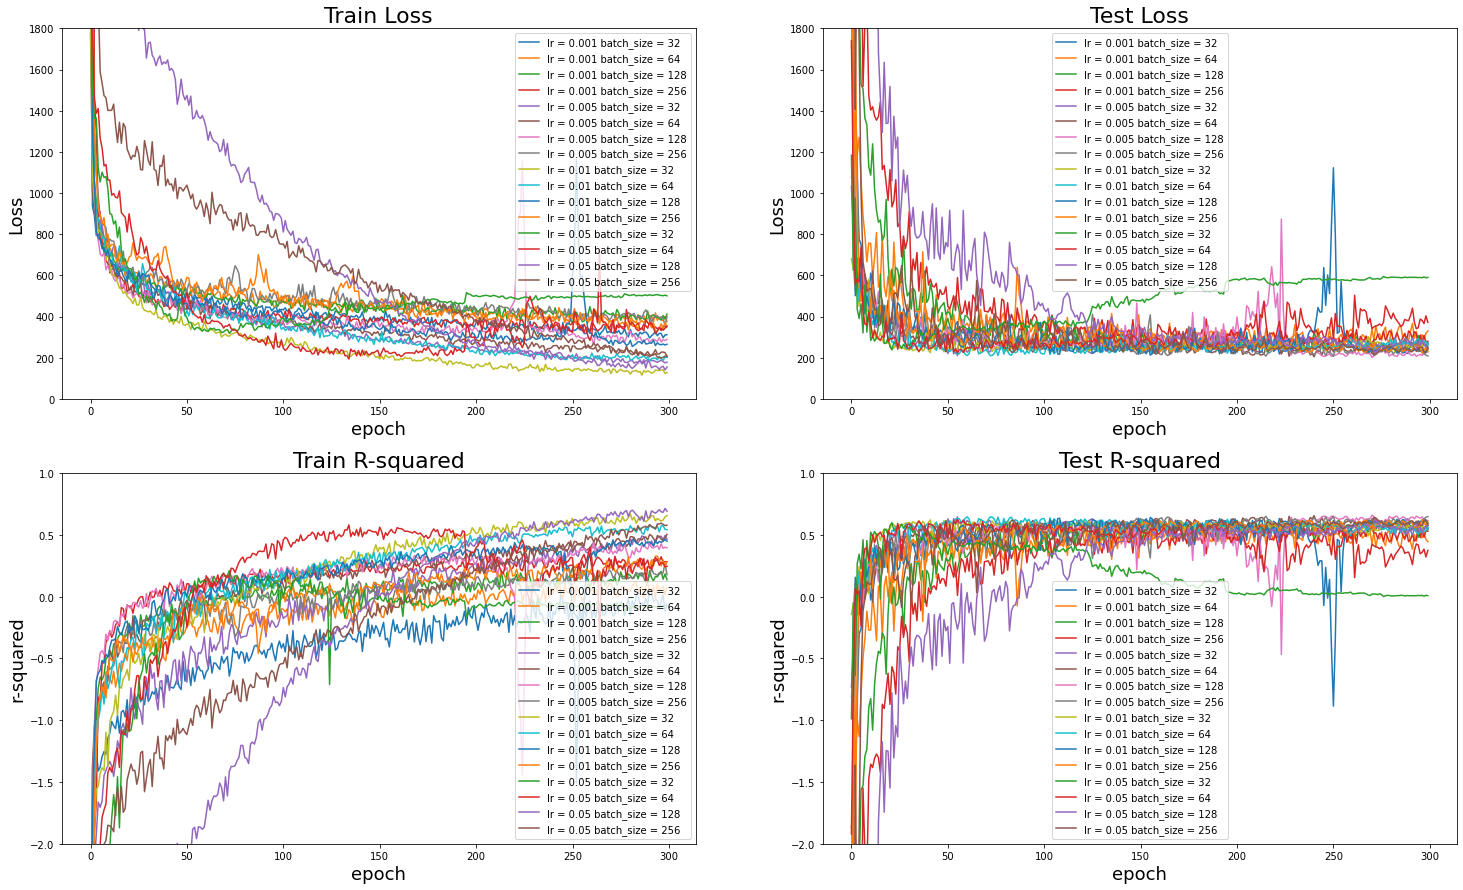

<Figure size 1800x1080 with 0 Axes>

In [12]:
def plot_all(ax, data_list):
    ax.plot(data_list[0],label="lr = 0.001 batch_size = 32")
    ax.plot(data_list[1],label="lr = 0.001 batch_size = 64")
    ax.plot(data_list[2],label="lr = 0.001 batch_size = 128")
    ax.plot(data_list[3],label="lr = 0.001 batch_size = 256")

    ax.plot(data_list[4],label="lr = 0.005 batch_size = 32")
    ax.plot(data_list[5],label="lr = 0.005 batch_size = 64")
    ax.plot(data_list[6],label="lr = 0.005 batch_size = 128")
    ax.plot(data_list[7],label="lr = 0.005 batch_size = 256")

    ax.plot(data_list[8],label="lr = 0.01 batch_size = 32")
    ax.plot(data_list[9],label="lr = 0.01 batch_size = 64")
    ax.plot(data_list[10],label="lr = 0.01 batch_size = 128")
    ax.plot(data_list[11],label="lr = 0.01 batch_size = 256")

    ax.plot(data_list[12],label="lr = 0.05 batch_size = 32")
    ax.plot(data_list[13],label="lr = 0.05 batch_size = 64")
    ax.plot(data_list[14],label="lr = 0.05 batch_size = 128")
    ax.plot(data_list[15],label="lr = 0.05 batch_size = 256")

figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure(figsize=(25,15))
ax1.set_title("Train Loss", fontsize=22)
plot_all(ax1, train_losses_all)
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("Loss", fontsize=18)
ax1.legend()
ax1.set_ylim([0, 1800])

ax2.set_title("Test Loss", fontsize=22)
plot_all(ax2, test_losses_all)
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("Loss", fontsize=18)
ax2.legend()
ax2.set_ylim([0, 1800])

ax3.set_title("Train R-squared", fontsize=22)
plot_all(ax3, train_accs_all)
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-2,1])

ax4.set_title("Test R-squared", fontsize=22)
plot_all(ax4, test_accs_all)
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-2,1])

plt.show()

In [13]:
for data in train_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in test_accs_all:
    print(data[-1])
    
print("___________________\n")

for data in train_losses_all:
    print(data[-1])

print("___________________\n")

for data in test_losses_all:
    print(data[-1])   
    

-0.05522390838832263
0.07441963449671456
0.13776137049707854
0.28268495505586005
0.4643303711094285
0.5046641139590624
0.39527786240636864
0.17913069847142282
0.6567896369224127
0.5423829480231442
0.44918945115125997
0.28174645489251937
-0.06811441710493858
0.24522192370630097
0.6923256795581455
0.5791431387017849
___________________

0.5425200122472507
0.4453373329728
0.5548728573709887
0.5292029078187588
0.5486712671192351
0.5916973185222043
0.6177694445766478
0.6479803113061015
0.6118079718263638
0.5628295951669968
0.5951840255655969
0.5983389496602627
0.008505438233472828
0.37476345953060997
0.5774496836960654
0.5791696423348601
___________________

312.5813978809421
377.53926849365234
412.32640584309894
353.3223762512207
179.18300499350337
209.293354288737
289.3610066731771
400.26712799072266
128.20786595748643
202.12200266520182
266.08257548014325
351.41878509521484
501.0816618062682
353.0127471923828
155.4384511311849
206.10049057006836
___________________

272.5497741699219
330

### 2 best models

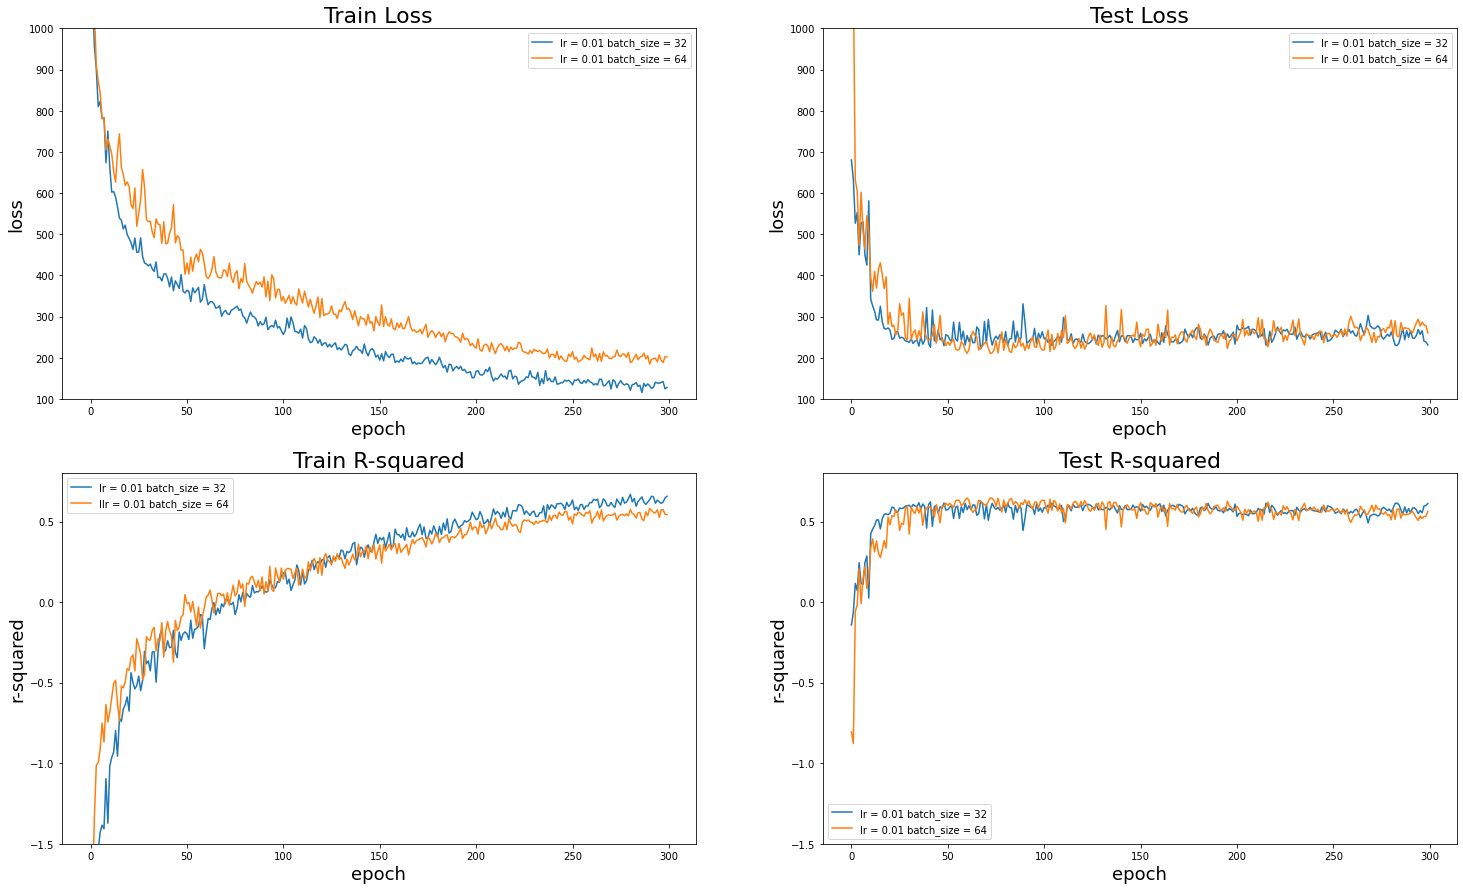

<Figure size 432x288 with 0 Axes>

In [14]:
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(25,15))
plt.figure()
ax1.set_title("Train Loss", fontsize=22)
ax1.plot(train_losses_all[8],label="lr = 0.01 batch_size = 32")
ax1.plot(train_losses_all[9],label="lr = 0.01 batch_size = 64")
ax1.set_xlabel("epoch", fontsize=18)
ax1.set_ylabel("loss", fontsize=18)
ax1.legend()
ax1.set_ylim([100, 1000])

ax2.set_title("Test Loss", fontsize=22)
ax2.plot(test_losses_all[8],label="lr = 0.01 batch_size = 32")
ax2.plot(test_losses_all[9],label="lr = 0.01 batch_size = 64")
ax2.set_xlabel("epoch", fontsize=18)
ax2.set_ylabel("loss", fontsize=18)
ax2.legend()
ax2.set_ylim([100, 1000])

ax3.set_title("Train R-squared", fontsize=22)
ax3.plot(train_accs_all[8],label="lr = 0.01 batch_size = 32")
ax3.plot(train_accs_all[9],label="llr = 0.01 batch_size = 64")
ax3.set_xlabel("epoch", fontsize=18)
ax3.set_ylabel("r-squared", fontsize=18)
ax3.legend()
ax3.set_ylim([-1.5,0.8])

ax4.set_title("Test R-squared", fontsize=22)
ax4.plot(test_accs_all[8],label="lr = 0.01 batch_size = 32")
ax4.plot(test_accs_all[9],label="lr = 0.01 batch_size = 64")
ax4.set_xlabel("epoch", fontsize=18)
ax4.set_ylabel("r-squared", fontsize=18)
ax4.legend()
ax4.set_ylim([-1.5,0.8])
plt.show()

## 4.2. Training

In [15]:
train_dataset = TensorDataset(torch.FloatTensor(X_train_all.values), torch.FloatTensor(y_train_all.values.reshape(-1, 1)))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test.values), torch.FloatTensor(y_test.values.reshape(-1, 1)))
test_loader = DataLoader(test_dataset, batch_size=533, shuffle=False)

In [16]:
model = FCNN()
model.cuda()

epochs = 300
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

train_losses = []
test_losses = []
train_accs = []
test_accs = []

best_value = 1000
best_params = {'epoch': None, 'train_loss': None, 'test_loss': None,'train_acc': None,'test_acc': None}
writer = SummaryWriter()

for epoch in range(1, epochs + 1):
    
    print('################## EPOCH {} ##################'.format(epoch))
    
    model.train()
    train_correct = 0
    train_loss = 0

    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_acc = train_correct/len(train_loader)
    train_accs.append(train_acc)
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("R2/train", train_acc, epoch)
    print('Train Avg. loss: {}, Accuracy: {}'.format(train_loss, train_acc))
    
    model.eval()
    
    test_loss = 0
    test_correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            test_correct += metrics.r2_score(target.cpu().detach().numpy(), output.cpu().detach().numpy())
        
    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    test_acc =test_correct/len(test_loader)
    test_accs.append(test_acc)

    if test_loss<best_value:
        best_value = test_loss
        torch.save(model.state_dict(), '../../models/protein_klek_fcnn_model.pt')
        best_params['epoch'] = epoch
        best_params['train_loss'] = train_loss
        best_params['test_loss'] = test_loss
        best_params['train_acc'] = train_acc
        best_params['test_acc'] = test_acc 
    writer.add_scalar("Loss/test", test_loss, epoch)
    writer.add_scalar("R2/test", test_acc, epoch)

    print('Test Avg. loss: {}, Accuracy: {}'.format(test_loss, test_acc))

writer.flush()
writer.close()

print(best_params)

################## EPOCH 1 ##################
Train Avg. loss: 1892.5444836972365, Accuracy: -4.309939207575316
Test Avg. loss: 550.8584594726562, Accuracy: -0.1936725981536107
################## EPOCH 2 ##################
Train Avg. loss: 1113.3387806451142, Accuracy: -2.1209488756450425
Test Avg. loss: 545.8712768554688, Accuracy: -0.18286569820263643
################## EPOCH 3 ##################
Train Avg. loss: 1029.4617901702425, Accuracy: -1.9747276790638484
Test Avg. loss: 399.2164611816406, Accuracy: 0.13492530824964433
################## EPOCH 4 ##################
Train Avg. loss: 939.4123512381938, Accuracy: -1.8124069551111486
Test Avg. loss: 415.1898193359375, Accuracy: 0.10031214815773015
################## EPOCH 5 ##################
Train Avg. loss: 824.5109968043085, Accuracy: -1.2981741765569668
Test Avg. loss: 340.8412780761719, Accuracy: 0.26142037750451674
################## EPOCH 6 ##################
Train Avg. loss: 855.2204070589436, Accuracy: -1.5071251338303866


Train Avg. loss: 389.82736889284047, Accuracy: -0.193073888314574
Test Avg. loss: 270.3961181640625, Accuracy: 0.4140701749897716
################## EPOCH 48 ##################
Train Avg. loss: 385.8065171882288, Accuracy: -0.22953314297969787
Test Avg. loss: 203.1430206298828, Accuracy: 0.5598030033602343
################## EPOCH 49 ##################
Train Avg. loss: 390.4028445571216, Accuracy: -0.21035423624786764
Test Avg. loss: 185.27549743652344, Accuracy: 0.5985207181579278
################## EPOCH 50 ##################
Train Avg. loss: 386.8215855840427, Accuracy: -0.15344767964107597
Test Avg. loss: 214.9506378173828, Accuracy: 0.5342166982083336
################## EPOCH 51 ##################
Train Avg. loss: 363.0976314259999, Accuracy: -0.13853481528168027
Test Avg. loss: 214.74757385253906, Accuracy: 0.5346567044725923
################## EPOCH 52 ##################
Train Avg. loss: 360.9330708517957, Accuracy: -0.19929867365459575
Test Avg. loss: 194.14593505859375, Accura

Train Avg. loss: 287.43693770223587, Accuracy: 0.14155221494117132
Test Avg. loss: 202.18641662597656, Accuracy: 0.5618759204109334
################## EPOCH 94 ##################
Train Avg. loss: 281.85131756227406, Accuracy: 0.14633884192617988
Test Avg. loss: 202.18008422851562, Accuracy: 0.5618896213140903
################## EPOCH 95 ##################
Train Avg. loss: 275.5877585339902, Accuracy: 0.15673780735733897
Test Avg. loss: 181.74252319335938, Accuracy: 0.6061764098247955
################## EPOCH 96 ##################
Train Avg. loss: 283.591648272614, Accuracy: 0.15238078947816888
Test Avg. loss: 184.3942413330078, Accuracy: 0.6004303008895744
################## EPOCH 97 ##################
Train Avg. loss: 247.58022205865205, Accuracy: 0.21129056653170444
Test Avg. loss: 172.8907470703125, Accuracy: 0.6253576284268181
################## EPOCH 98 ##################
Train Avg. loss: 260.85344832690794, Accuracy: 0.2156100725323762
Test Avg. loss: 179.3269500732422, Accuracy:

Train Avg. loss: 201.24524062427122, Accuracy: 0.446801150680778
Test Avg. loss: 188.66946411132812, Accuracy: 0.5911661728568743
################## EPOCH 140 ##################
Train Avg. loss: 194.77721792192602, Accuracy: 0.39928210079698934
Test Avg. loss: 181.82522583007812, Accuracy: 0.6059971777873188
################## EPOCH 141 ##################
Train Avg. loss: 209.9165479745438, Accuracy: 0.3808814870290697
Test Avg. loss: 184.8248748779297, Accuracy: 0.5994971570754821
################## EPOCH 142 ##################
Train Avg. loss: 187.91276504744346, Accuracy: 0.4443189139218374
Test Avg. loss: 178.14788818359375, Accuracy: 0.6139657424403341
################## EPOCH 143 ##################
Train Avg. loss: 193.84060372879256, Accuracy: 0.41103175445461937
Test Avg. loss: 183.3804473876953, Accuracy: 0.6026271239923164
################## EPOCH 144 ##################
Train Avg. loss: 194.6645433795986, Accuracy: 0.45942158339066236
Test Avg. loss: 190.0693817138672, Accura

Train Avg. loss: 167.5555900459859, Accuracy: 0.5358038013204561
Test Avg. loss: 186.80319213867188, Accuracy: 0.5952102901279044
################## EPOCH 186 ##################
Train Avg. loss: 171.7599153661016, Accuracy: 0.5299801506550285
Test Avg. loss: 191.80540466308594, Accuracy: 0.5843708391648025
################## EPOCH 187 ##################
Train Avg. loss: 161.3696543565437, Accuracy: 0.5281823153120104
Test Avg. loss: 181.36865234375, Accuracy: 0.6069865728068027
################## EPOCH 188 ##################
Train Avg. loss: 161.37483670818273, Accuracy: 0.5417334353233783
Test Avg. loss: 176.46754455566406, Accuracy: 0.617606912829985
################## EPOCH 189 ##################
Train Avg. loss: 156.37027603832644, Accuracy: 0.5733736246858577
Test Avg. loss: 171.20236206054688, Accuracy: 0.6290162584285821
################## EPOCH 190 ##################
Train Avg. loss: 159.48446154238573, Accuracy: 0.5550697418201895
Test Avg. loss: 180.11512756347656, Accuracy: 

Train Avg. loss: 163.84808827869927, Accuracy: 0.5438262422124022
Test Avg. loss: 184.6552276611328, Accuracy: 0.5998647876422208
################## EPOCH 233 ##################
Train Avg. loss: 143.31015965475964, Accuracy: 0.6039743701039724
Test Avg. loss: 190.28150939941406, Accuracy: 0.5876730207217312
################## EPOCH 234 ##################
Train Avg. loss: 144.00839808449817, Accuracy: 0.6099161872701239
Test Avg. loss: 185.0823211669922, Accuracy: 0.5989392992985116
################## EPOCH 235 ##################
Train Avg. loss: 144.20148268742346, Accuracy: 0.6238966758921122
Test Avg. loss: 178.42178344726562, Accuracy: 0.6133722282827343
################## EPOCH 236 ##################
Train Avg. loss: 141.60968854534093, Accuracy: 0.6189225873511377
Test Avg. loss: 190.76541137695312, Accuracy: 0.5866244316139992
################## EPOCH 237 ##################
Train Avg. loss: 148.23396745368615, Accuracy: 0.6123643461080032
Test Avg. loss: 176.5083770751953, Accura

Train Avg. loss: 140.9510695044674, Accuracy: 0.6116445606327789
Test Avg. loss: 187.68093872070312, Accuracy: 0.5933082818979805
################## EPOCH 279 ##################
Train Avg. loss: 144.1331061178179, Accuracy: 0.6270049759896045
Test Avg. loss: 181.86036682128906, Accuracy: 0.605921030176582
################## EPOCH 280 ##################
Train Avg. loss: 135.03672044668625, Accuracy: 0.6565120129759827
Test Avg. loss: 188.70904541015625, Accuracy: 0.5910804332216131
################## EPOCH 281 ##################
Train Avg. loss: 136.92955068332046, Accuracy: 0.6454079122089951
Test Avg. loss: 190.7763671875, Accuracy: 0.586600679982461
################## EPOCH 282 ##################
Train Avg. loss: 150.89872855570778, Accuracy: 0.594750406285146
Test Avg. loss: 195.57456970214844, Accuracy: 0.5762033324929893
################## EPOCH 283 ##################
Train Avg. loss: 140.47720741158102, Accuracy: 0.6532071040289437
Test Avg. loss: 190.0850067138672, Accuracy: 0.5

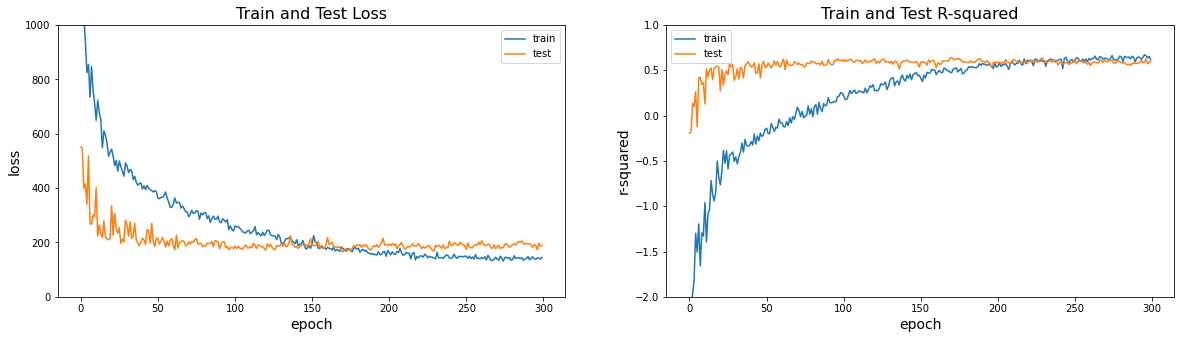

<Figure size 1440x360 with 0 Axes>

In [18]:
figure, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
plt.figure(figsize=(20,5))
ax1.set_title("Train and Test Loss", fontsize=16)
ax1.plot(train_losses,label="train")
ax1.plot(test_losses,label="test")
ax1.set_xlabel("epoch", fontsize=14)
ax1.set_ylabel("loss", fontsize=14)
ax1.legend()
ax1.set_ylim([0,1000])

ax2.set_title("Train and Test R-squared", fontsize=16)
ax2.plot(train_accs,label="train")
ax2.plot(test_accs,label="test")
ax2.set_xlabel("epoch", fontsize=14)
ax2.set_ylabel("r-squared", fontsize=14)
ax2.legend()
ax2.set_ylim([-2,1])
plt.show()

In [19]:
model = FCNN()
model.load_state_dict(torch.load('../../models/protein_klek_fcnn_model.pt'))
model.cuda()
model.eval()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        output = model(data)
        predictons = output.cpu().detach().numpy()
        print_evaluate(target.cpu().detach().numpy(), predictons)

MAE: 7.5969524
MSE: 165.36835
RMSE: 12.859563
R2 Square 0.641658108196149 

